# Histórico de Bitácoras Onomásticas del SEMEFO-DF
# Análisis de datos por tipo de restos y contexto histórico


-------

El **Servicio Médico Forense del Distrito Federal (SEMEFO-DF)** ahora [INCIFO-CdMx](https://www.incifocdmx.gob.mx/) es una institución oficial encargada de realizar autopsias y estudios forenses para esclarecer las causas de muerte, principalmente en casos de muertes violentas, sospechosas o relacionadas con hechos delictivos. 
El **Histórico de Bitácoras Onomásticas (HBO)** son registros administrativos utilizados por el SEMEFO-DF entre **1968 y 1982** para documentar el ingreso de cadáveres o restos humanos a sus instalaciones. 
Estas bitácoras contienen información individualizada sobre cada ingreso, como: nombre, fecha de ingreso, edad, diagnóstico de causa de muerte, expediente del SEMEFO, institución de procedencia y acta. 
Entre 2020 y 2023, la CNB accedió a estos documentos, resguardados por el INCIFO-CdMx, para digitalizar, transcribir e interpretar las anotaciones manuscritas. La base de datos se hizo pública por medio de la solicitud de acceso a la información 332163723000249 como un archivo en formato Excel.
Estos registros incluyen datos clave para identificar patrones históricos de mortalidad, enfermedades comunes y factores de riesgo, lo que las convierte en una fuente valiosa para estudios demográficos, epidemiológicos y de salud pública.

Esta serie de notebooks documenta el proceso de análisis al cual fue sometido el HBO. 
1. [/] Estadística descriptiva de variables: ver perfil de datos `HBO_profile_clean`
2. [/] Completitud de variables
3. [/] Comparación entre grupos según tipo de restos
    * [/] Categóricas: tablas de contingencia, chi^2
        * [/] Extra: aluvial des/conocido, tipo_restos, sexo 
    * [/] Texto: cadenas con mayor frecuencia y wordcloud
    * [/] Proceso administrativo: distribución en bitácoras y wordcloud
        * [/] Extra: mapa de procedencia_alcaldia
    * [/] Numéricas: medidas de tendencia central y dispersión, chi^2, Mann-Whitney U
        * [/] Extra: estimación de distribución de edad con KDE
4. [/] Comparación con datos históricos
    * [/] Asociación ingresos y decesos DF: chi^2 y regresion lineal
    * [/] Ingresos anuales por sexo: gráfica
    * [/] Distribución grupo etario
5. [ ] Red de coocurrencia de diagnósticos: ver `HBO_analisis_diag`
6. [ ] Asociación entre diagnóstico y tipo restos, sexo y edad grupo:  ver `HBO_analisis_diag`
    * [ ] chi-cuadrado con corrección (clasificación vs. tipo restos/sexo)
    * [ ] clustermap (clasificación vs. edad grupo)
7. [ ] Asociación entre procedencia y tipo de restos y sexo:
    * [ ] chi-cuadrado (clasificación vs. tipo restos/sexo)
    * [ ] clustermap (alcaldía vs. tipo restos)
8. [-] Análisis temporal

In [1]:
from joblib import load
import pandas as pd
import numpy as np
from numpy import nan
from helper_pandas import *
from scipy.stats import chi2_contingency, gaussian_kde, mannwhitneyu, pearsonr
import statsmodels.api as sm

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

in_file = "data_clean/HBO_clean.pkl"
with open(in_file, 'rb') as f:
     df = load(f)

#Quitar filas vacias
df = df[df['Identificacion']!='S-D']
display( df.shape )
df.tail()

(96825, 31)

Numero_progresivo_transcrito  \
ID                                           
BO_1982_07489                          S-D   
BO_1982_07490                          S-D   
BO_1982_07491                          S-D   
BO_1982_07492                          S-D   
BO_1982_07493                          S-D   

                           Nombre_completo_transcrito Primer_apellido  \
ID                                                                      
BO_1982_07489                                placenta             NaN   
BO_1982_07490  5 dedos del pie derecho de desconocido             NaN   
BO_1982_07491                     dedo de desconocido             NaN   
BO_1982_07492                  4 dedos de desconocido             NaN   
BO_1982_07493                 osamenta de desconocido             NaN   

              Segundo_apellido Nombres_propios Fecha_transcrito  \
ID                                                                
BO_1982_07489              NaN             NaN       1982-06-05   
BO_1982_07490              NaN             NaN       1982-06-05   
BO_1982_07491              NaN             NaN       1982-11-19   
BO_1982_07492              NaN             NaN       1982-11-28   
BO_1982_07493              NaN             NaN       1982-10-11   

              Fecha_estandar Fecha_año Fecha_mes Fecha_semana  ...  \
ID                                                             ...   
BO_1982_07489     1982-06-05    1982.0       6.0           22  ...   
BO_1982_07490     1982-06-05    1982.0       6.0           22  ...   
BO_1982_07491     1982-11-19    1982.0      11.0           46  ...   
BO_1982_07492     1982-11-28    1982.0      11.0           47  ...   
BO_1982_07493     1982-10-11    1982.0      10.0           41  ...   

              Procedencia_transcrito Procedencia_estandar  \
ID                                                          
BO_1982_07489                    15a                GAM-2   
BO_1982_07490                    32a                COY-2   
BO_1982_07491                    32a                COY-2   
BO_1982_07492                    27a                 XO-2   
BO_1982_07493                     9a                 MH-1   

                                           Procedencia_extendido  \
ID                                                                 
BO_1982_07489  Coord Territorial 2 Gustavo A Madero (Col Arag...   
BO_1982_07490  Coord Territorial 2 Coyoacan (Col Romero de Te...   
BO_1982_07491  Coord Territorial 2 Coyoacan (Col Romero de Te...   
BO_1982_07492  Coord Territorial 2 Xochimilco (Barrio de San ...   
BO_1982_07493  Coord Territorial 1 Miguel Hidalgo – Hospital ...   

               Procedencia_alcaldia Procedencia_clasificacion  \
ID                                                              
BO_1982_07489      Gustavo A Madero                  Judicial   
BO_1982_07490              Coyoacan                  Judicial   
BO_1982_07491              Coyoacan                  Judicial   
BO_1982_07492            Xochimilco                  Judicial   
BO_1982_07493        Miguel Hidalgo                  Hospital   

              Numero_acta_transcrito Expediente_SEMEFO_transcrito  \
ID                                                                  
BO_1982_07489                    960                         3079   
BO_1982_07490                    950                         3060   
BO_1982_07491                   2005                         6389   
BO_1982_07492                    959                         6528   
BO_1982_07493                   4193                         5629   

               Bitacora_ingresos Foja_transcrito  \
ID                                                 
BO_1982_07489  semefo_df_bo_1982             156   
BO_1982_07490  semefo_df_bo_1982             156   
BO_1982_07491  semefo_df_bo_1982             156   
BO_1982_07492  semefo_df_bo_1982             156   
BO_1982_07493  semefo_df_bo_1982             156   

        

### Código de color

1. <span style="background:#0504aa">---</span> Poblacion
2. <span style="background:#999999">---</span> S-D  <span style="background:#d9d9d9">---</span> S-D (DF)
3. <span style="background:#377eb8">---</span> Masculino  <span style="background:#80b1d3">---</span> Masculino (DF)
4. <span style="background:#984ea3">---</span> Femenino  <span style="background:#bebada">---</span> Femenino (DF)
5. <span style="background:#4daf4a">---</span> Conocido
6. <span style="background:#dbb40c">---</span> Desconocido
7. <span style="background:#04d8b2">---</span> Cadáver conocido
8. <span style="background:#fdff52">---</span> Cadáver desconocido
9. <span style="background:#c875c4">---</span> Recién nacido
10. <span style="background:#ff7f00">---</span> Feto
11. <span style="background:#f781bf">---</span> Miembros
12. <span style="background:#c85a53">---</span> Restos óseos 

In [2]:
from matplotlib.colors import LinearSegmentedColormap

dic_color = {'Poblacion':'#0504aa', 'Conocido':'#4daf4a', 'Desconocido':'#dbb40c', 
             'S-D':'#999999', 'S-D (SEMEFO)':'#999999', 'S-D (DF)':'#d9d9d9', 
             'Masculino':'#377eb8', 'Masculino (SEMEFO)':'#377eb8', 'Masculino (DF)':'#80b1d3', 
             'Femenino':'#984ea3', 'Femenino (SEMEFO)':'#984ea3', 'Femenino (DF)':'#bebada', 
             'Cadáver conocido':'#04d8b2', 'Cadáver desconocido':'#fdff52', 
             'Recién nacido':'#c875c4', 'Feto':'#ff7f00', 'Miembros':'#f781bf', 'Restos óseos':'#c85a53', }
gray_to_green = LinearSegmentedColormap.from_list('gray_to_green', ['#d9d9d9', '#2a7e19'])


## Completitud de variables

### Datos faltantes por columna transcrita

In [3]:
col_trans = [c for c in df.columns if 'transcrito' in c]
ingresos_anuales = df['Bitacora_ingresos'].value_counts().sort_index()

df_notnan = (df[col_trans]!='S-D')
df_notnan.sum()

Numero_progresivo_transcrito    27152
Nombre_completo_transcrito      96819
Fecha_transcrito                96611
Edad_transcrito                 40183
Diagnostico_transcrito          40966
Procedencia_transcrito          71064
Numero_acta_transcrito          71102
Expediente_SEMEFO_transcrito    96277
Foja_transcrito                 88845
dtype: int64

**Datos faltantes por año**

No todos los años se capturaron todas las variables.

* Edad y Diagnóstico solo fueron capturadas de 1974-1979
* Numero progresivo solo fue capturada de 1974 a 1978 y fue de manera irregular
* Procedencia y acta fueron capturadas de manera irregular de 1968 a 1963
* Foja no fue capturada en 1980

Ignorando las variables que no fueron capturadas en el año

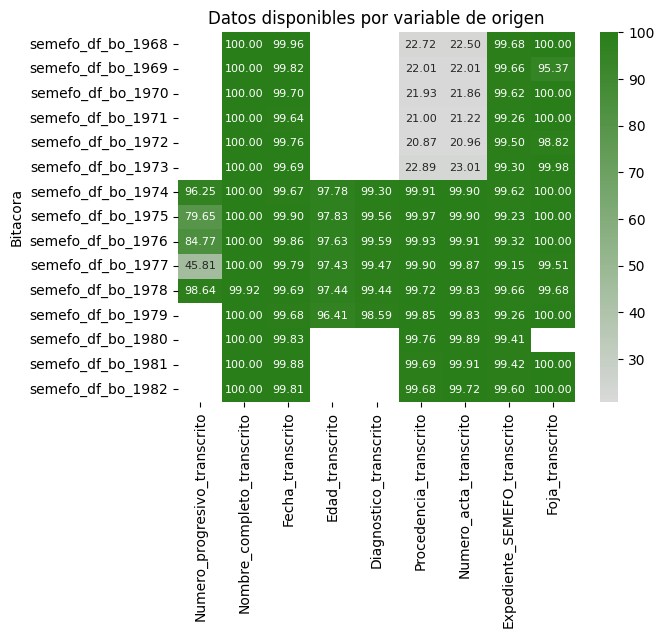

In [4]:
ingresos_anuales = df['Bitacora_ingresos'].value_counts().sort_index()

df_notnan['Bitacora'] = df['Bitacora_ingresos']
df_notnan_anual = df_notnan.groupby('Bitacora').sum().divide( ingresos_anuales, axis=0 )

dic_miss_año = { 'Numero_progresivo_transcrito': ['1968','1969','1970','1971','1972','1973','1979','1980','1981','1982'],
                'Edad_transcrito': ['1968','1969','1970','1971','1972','1973','1980','1981','1982'],
                'Diagnostico_transcrito': ['1968','1969','1970','1971','1972','1973','1980','1981','1982'],
                'Foja_transcrito': ['1980'] }  
for col, años in dic_miss_año.items():
    df_notnan.loc[ df_notnan['Bitacora'].isin([f"semefo_df_bo_{a}" for a in años]), col] = nan
df_notnan

df_notnan_anual = df_notnan.groupby('Bitacora', dropna=False) \
                            .apply(lambda x: x.sum(skipna=False)) \
                            .divide( ingresos_anuales, axis=0 )
sns.heatmap(df_notnan_anual*100, cmap=gray_to_green, annot=True, fmt=".2f", annot_kws={"size": 8})
plt.title(f"Datos disponibles por variable de origen")
#plt.savefig("imagenes/BO_VariableFaltante+Año.svg")
plt.show()

Correlación entre faltantes
* Existe una correlación alta  (0.996) entre la falta de procedencia y de acta.
* Existe una correlación debil entre la falta del nombre con la fecha (0.253) y el exp semefo (0.162)


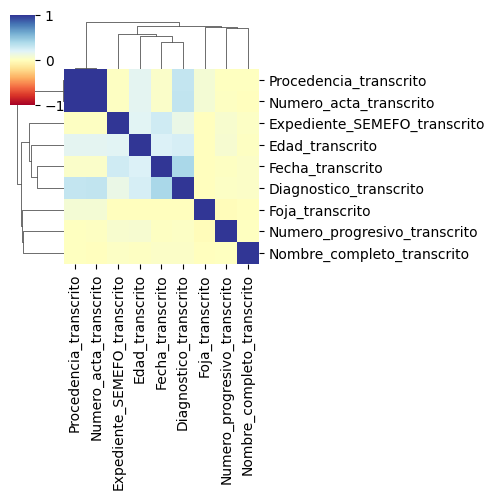

In [5]:
sns.clustermap(df_notnan.drop('Bitacora', axis=1).corr(), vmin=-1, vmax=1, cmap='RdYlBu', figsize=(5,5))
plt.show()

### Filas con más datos faltantes

* Casos donde hay número progresivo o foja pero ningun dato
* Casos donde solo hay nombre, muchas veces solo apellido
* Casos sin fecha pero con expediente

En general no parece haber un patrón, la cantidad de datos esta fuertemente asociada a que campos se capturaron ese año

In [6]:
df_notnan = (df[col_trans]!='S-D')
df_notnan['Bitacora'] = df['Bitacora_ingresos']

dic_miss_año = { 'Numero_progresivo_transcrito': ['1968','1969','1970','1971','1972','1973','1979','1980','1981','1982'],
                'Edad_transcrito': ['1968','1969','1970','1971','1972','1973','1980','1981','1982'],
                'Diagnostico_transcrito': ['1968','1969','1970','1971','1972','1973','1980','1981','1982'],
                'Foja_transcrito': ['1980'] }  
for col, años in dic_miss_año.items():
    años = [f"semefo_df_bo_{a}" for a in años]
    df_notnan.loc[ df_notnan['Bitacora'].isin(años), col] = nan

df_notnan_row = df_notnan.drop('Bitacora', axis=1).sum(axis=1).to_frame()
df_notnan_row.value_counts().sort_index()

0
1        6
2       58
3      459
4    25153
5     7900
6    22190
7      615
8    14044
9    26400
Name: count, dtype: int64

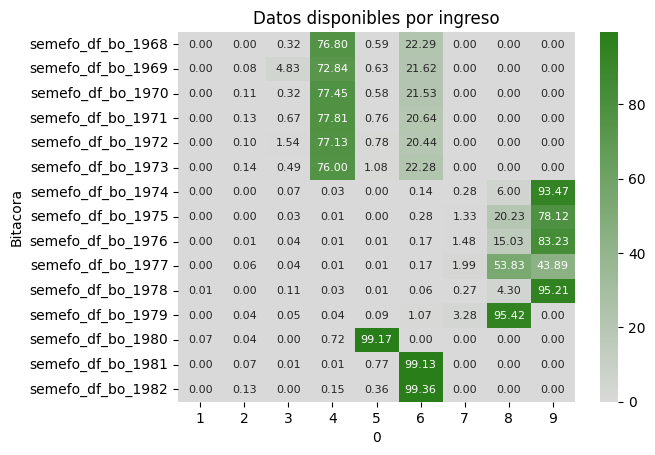

In [7]:
df_notnan_row['Bitacora'] = df['Bitacora_ingresos']
df_notnan_row_anual = df_notnan_row.pivot_table(columns=0, index='Bitacora', aggfunc='size')
df_notnan_row_anual = df_notnan_row_anual.divide(ingresos_anuales, axis=0)
sns.heatmap(df_notnan_row_anual*100, cmap=gray_to_green, annot=True, fmt=".2f", annot_kws={"size": 8})
plt.title(f"Datos disponibles por ingreso")
plt.show()

### Faltantes por tipo de restos

* De 1968 a 1973 faltan procedencia/acta para cadáveres conocidos
* De 1974 a 1979 faltan edades para miembros
* No todos los años hay restos oseos


Cadáver conocido


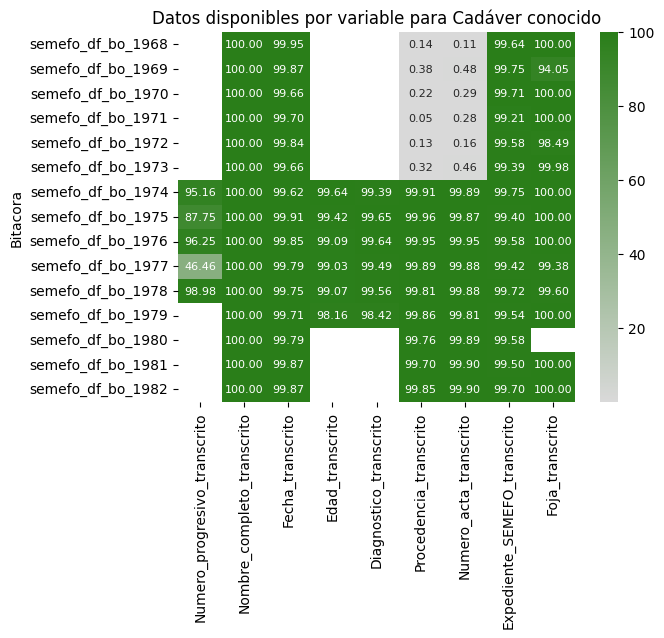

Cadáver desconocido


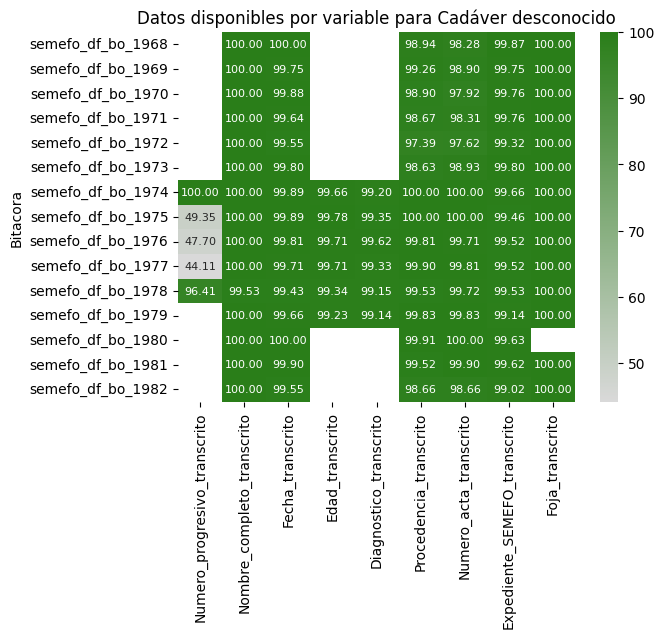

Miembros


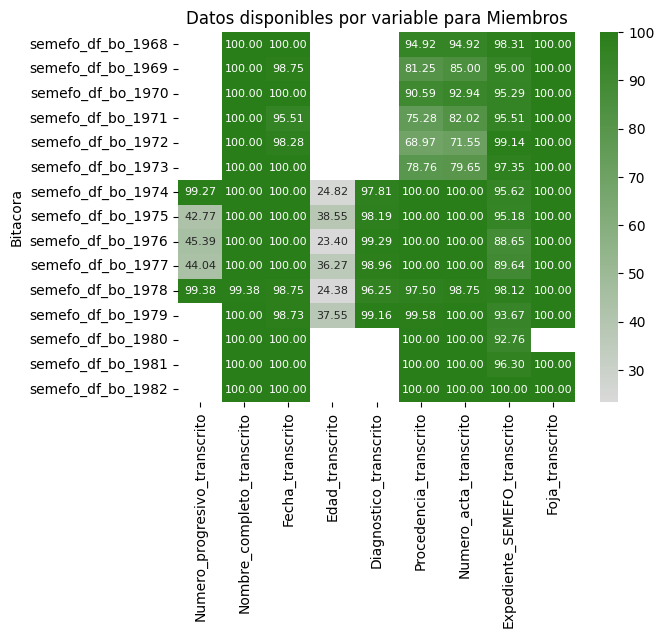

Feto


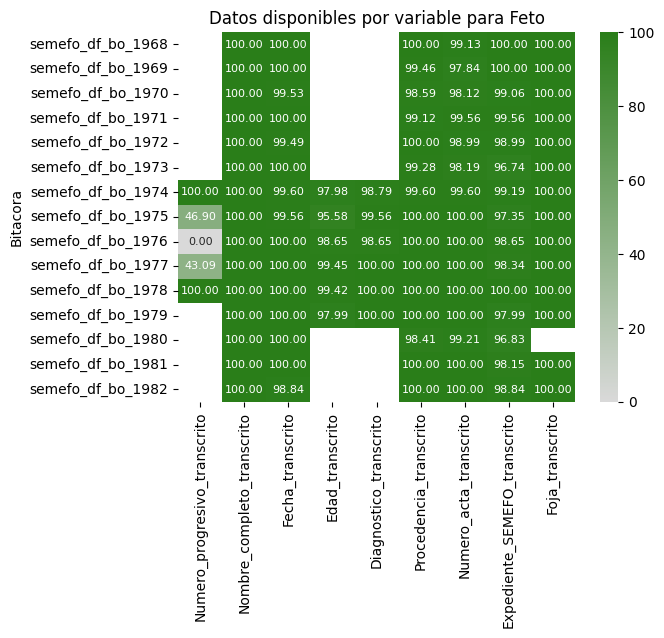

Restos óseos


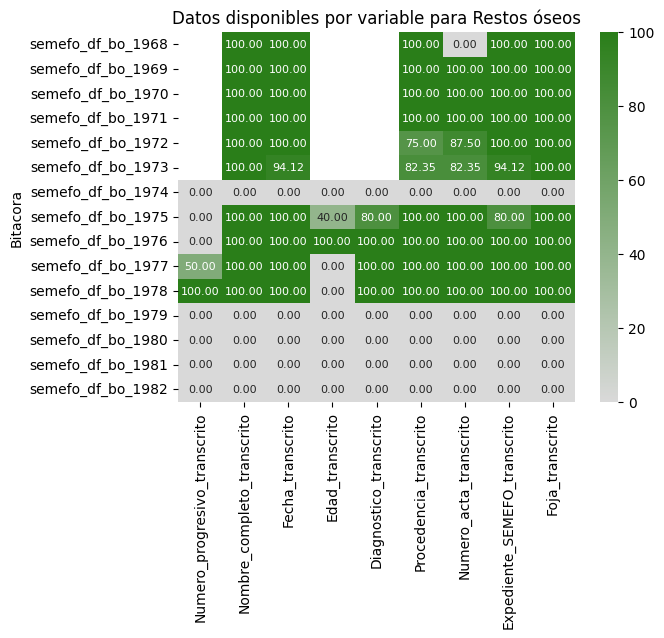

Recién nacido


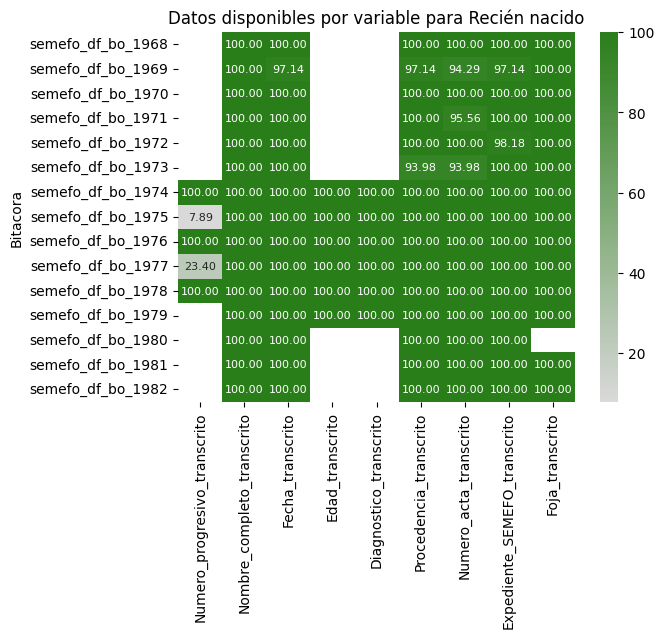

In [8]:
for tipo in df['Tipo_restos'].unique():
    print(tipo)
    ingresos_anuales_tipo = df.loc[df['Tipo_restos']==tipo,'Bitacora_ingresos'].value_counts().sort_index()
    ingresos_anuales_tipo = ingresos_anuales_tipo.replace({0:1.0})
    data = df_notnan[df['Tipo_restos']==tipo]
    data_anual = data.groupby('Bitacora', dropna=False) \
                     .apply(lambda x: x.sum(skipna=False)) \
                     .div( ingresos_anuales_tipo, axis=0 )
    for col in data_anual.columns:
        data_anual[col] = pd.to_numeric(data_anual[col]*100)
    sns.heatmap(data_anual, cmap=gray_to_green, annot=True, fmt=".2f", annot_kws={"size": 8})
    plt.title(f"Datos disponibles por variable para {tipo}")
    plt.show()

### Ingresos fuera de año de bitacora

* Sin fecha de ingreso
* Errores de conversión de fecha (29 de febrero)
* Último mes del año anterior
* Primer mes del año posterior
* Casos especiales
    * En la bitácora de 1973 hay varios de 1974, consecutivos de la v a la x
    * Casos del futuro
    * Podría ser cuestión de transcripción    

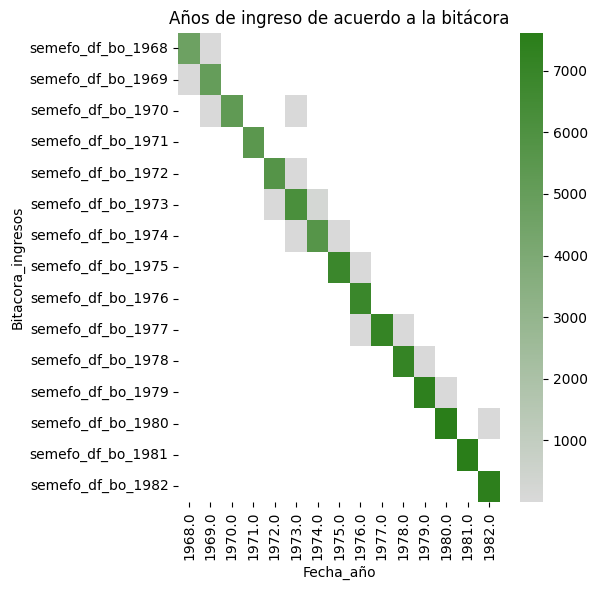

In [9]:
data = df.pivot_table(index='Bitacora_ingresos', columns='Fecha_año', aggfunc='size').replace(0,nan).sort_index()
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(ax=ax, data=data, cmap=gray_to_green, )
plt.title('Años de ingreso de acuerdo a la bitácora')
plt.tight_layout()
plt.show()

Revisión de casos

In [10]:
for bit in df['Bitacora_ingresos'].unique():
    print(bit)
    año_bit = int(bit.replace('semefo_df_bo_',''))
    display(bit, df[(df['Bitacora_ingresos']==bit) & (df['Fecha_año']!=año_bit) & (df['Fecha_transcrito']!='S-D')] )
    print('\n')
    

semefo_df_bo_1968


'semefo_df_bo_1968'

Numero_progresivo_transcrito Nombre_completo_transcrito  \
ID                                                                      
BO_1968_04658                          S-D   valadez alanis francisco   
BO_1968_04659                          S-D   vazquez contreras carlos   

              Primer_apellido Segundo_apellido Nombres_propios  \
ID                                                               
BO_1968_04658         valadez           alanis       francisco   
BO_1968_04659         vazquez        contreras          carlos   

              Fecha_transcrito Fecha_estandar Fecha_año Fecha_mes  \
ID                                                                  
BO_1968_04658       1969-01-01     1969-01-01    1969.0       1.0   
BO_1968_04659       1969-07-28     1969-07-28    1969.0       7.0   

              Fecha_semana  ... Procedencia_transcrito Procedencia_estandar  \
ID                          ...                                               
BO_1968_04658            1  ...                    S-D                  NaN   
BO_1968_04659           31  ...                    S-D                  NaN   

              Procedencia_extendido  Procedencia_alcaldia  \
ID                                                          
BO_1968_04658                   NaN                   NaN   
BO_1968_04659                   NaN                   NaN   

              Procedencia_clasificacion Numero_acta_transcrito  \
ID                                                               
BO_1968_04658                       NaN                    S-D   
BO_1968_04659                       NaN                    S-D   

              Expediente_SEMEFO_transcrito  Bitacora_ingresos Foja_transcrito  \
ID                                                                              
BO_1968_04658                         4875  semefo_df_bo_1968     121 reverso   
BO_1968_04659                         4815  semefo_df_bo_1968     121 reverso   

                                      Observaciones  
ID                                                   
BO_1968_04658  se indica que fue entregado en 1969.  
BO_1968_04659  se indica que fue entregado en 1969.  

[2 rows x 31 columns]



semefo_df_bo_1969


'semefo_df_bo_1969'

Numero_progresivo_transcrito Nombre_completo_transcrito  \
ID                                                                      
BO_1969_03629                          S-D         olmos montoya jose   

              Primer_apellido Segundo_apellido Nombres_propios  \
ID                                                               
BO_1969_03629           olmos          montoya            jose   

              Fecha_transcrito Fecha_estandar Fecha_año Fecha_mes  \
ID                                                                  
BO_1969_03629       1968-12-31     1968-12-31    1968.0      12.0   

              Fecha_semana  ... Procedencia_transcrito Procedencia_estandar  \
ID                          ...                                               
BO_1969_03629            1  ...                    S-D                  NaN   

              Procedencia_extendido  Procedencia_alcaldia  \
ID                                                          
BO_1969_03629                   NaN                   NaN   

              Procedencia_clasificacion Numero_acta_transcrito  \
ID                                                               
BO_1969_03629                       NaN                    S-D   

              Expediente_SEMEFO_transcrito  Bitacora_ingresos Foja_transcrito  \
ID                                                                              
BO_1969_03629                         4864  semefo_df_bo_1969              84   

                                                   Observaciones  
ID                                                                
BO_1969_03629  la fecha esta marcada como de 1968 en la bitac...  

[1 rows x 31 columns]



semefo_df_bo_1970


'semefo_df_bo_1970'

Numero_progresivo_transcrito      Nombre_completo_transcrito  \
ID                                                                           
BO_1970_01167                          S-D                     desconocido   
BO_1970_02996                          S-D          larios toscano agapito   
BO_1970_03091                          S-D  lorrabaquio cisneros guadalupe   
BO_1970_03234                          S-D             nombre confidencial   
BO_1970_03435                          S-D               may cruz santiago   

              Primer_apellido Segundo_apellido Nombres_propios  \
ID                                                               
BO_1970_01167             NaN              NaN             NaN   
BO_1970_02996          larios          toscano         agapito   
BO_1970_03091     lorrabaquio         cisneros       guadalupe   
BO_1970_03234              nc               nc              nc   
BO_1970_03435             may             cruz        santiago   

              Fecha_transcrito Fecha_estandar Fecha_año Fecha_mes  \
ID                                                                  
BO_1970_01167       1970-04-31            NaT       NaN       NaN   
BO_1970_02996       1970-02-29            NaT       NaN       NaN   
BO_1970_03091       1969-12-06     1969-12-06    1969.0      12.0   
BO_1970_03234       1970-02-29            NaT       NaN       NaN   
BO_1970_03435       1973-01-20     1973-01-20    1973.0       1.0   

              Fecha_semana  ... Procedencia_transcrito Procedencia_estandar  \
ID                          ...                                               
BO_1970_01167          NaN  ...                     HX                   HX   
BO_1970_02996          NaN  ...                    S-D                  NaN   
BO_1970_03091           49  ...                    S-D                  NaN   
BO_1970_03234          NaN  ...                     HX                   HX   
BO_1970_03435            3  ...                    S-D                  NaN   

                           Procedencia_extendido  Procedencia_alcaldia  \
ID                                                                       
BO_1970_01167  Hospital Xoco (Col General Anaya)         Benito Juarez   
BO_1970_02996                                NaN                   NaN   
BO_1970_03091                                NaN                   NaN   
BO_1970_03234  Hospital Xoco (Col General Anaya)         Benito Juarez   
BO_1970_03435                                NaN                   NaN   

              Procedencia_clasificacion Numero_acta_transcrito  \
ID                                                               
BO_1970_01167                  Hospital                  67732   
BO_1970_02996                       NaN                    S-D   
BO_1970_03091                       NaN                    S-D   
BO_1970_03234                  Hospital                  67145   
BO_1970_03435                       NaN                    S-D   

              Expediente_SEMEFO_transcrito  Bitacora_ingresos Foja_transcrito  \
ID                                                                              
BO_1970_01167                         1920  semefo_df_bo_1970              28   
BO_1970_02996                          S-D  semefo_df_bo_1970              92   
BO_1970_03091                         3132  semefo_df_bo_1970      93 reverso   
BO_1970_03234                          503  semefo_df_bo_1970      98 reverso   
BO_1970_03435                         2680  semefo_df_bo_1970     101 reverso   

                                                   Observaciones  
ID                                                                
BO_1970_01167  en la bitacora original se anoto 31 de abril, ...  
BO_1970_02996  1970 no fue un ano bisiesto, sin embargo en la...  
BO_1970_03091                   numero_acta levantada el 6-12-69  
BO_1970_03234  1970 no fue un ano bisiesto, sin embargo en la...  
BO_1970_03435 



semefo_df_bo_1971


'semefo_df_bo_1971'

Numero_progresivo_transcrito Nombre_completo_transcrito  \
ID                                                                      
BO_1971_00319                          S-D     benitez sanchez arturo   

              Primer_apellido Segundo_apellido Nombres_propios  \
ID                                                               
BO_1971_00319         benitez          sanchez          arturo   

              Fecha_transcrito Fecha_estandar Fecha_año Fecha_mes  \
ID                                                                  
BO_1971_00319       1971-02-29            NaT       NaN       NaN   

              Fecha_semana  ... Procedencia_transcrito Procedencia_estandar  \
ID                          ...                                               
BO_1971_00319          NaN  ...                    S-D                  NaN   

              Procedencia_extendido  Procedencia_alcaldia  \
ID                                                          
BO_1971_00319                   NaN                   NaN   

              Procedencia_clasificacion Numero_acta_transcrito  \
ID                                                               
BO_1971_00319                       NaN                    S-D   

              Expediente_SEMEFO_transcrito  Bitacora_ingresos Foja_transcrito  \
ID                                                                              
BO_1971_00319                          501  semefo_df_bo_1971               9   

                                                   Observaciones  
ID                                                                
BO_1971_00319  nota: (dispensa). 1971 no fue un ano bisiesto,...  

[1 rows x 31 columns]



semefo_df_bo_1972


'semefo_df_bo_1972'

Numero_progresivo_transcrito Nombre_completo_transcrito  \
ID                                                                      
BO_1972_05329                          S-D    torres mireles josefina   
BO_1972_05531                          S-D         vega bravo alfonso   

              Primer_apellido Segundo_apellido Nombres_propios  \
ID                                                               
BO_1972_05329          torres          mireles        josefina   
BO_1972_05531            vega            bravo         alfonso   

              Fecha_transcrito Fecha_estandar Fecha_año Fecha_mes  \
ID                                                                  
BO_1972_05329       1973-01-10     1973-01-10    1973.0       1.0   
BO_1972_05531       1972-02-30            NaT       NaN       NaN   

              Fecha_semana  ... Procedencia_transcrito Procedencia_estandar  \
ID                          ...                                               
BO_1972_05329            2  ...                    S-D                  NaN   
BO_1972_05531          NaN  ...                    S-D                  NaN   

              Procedencia_extendido  Procedencia_alcaldia  \
ID                                                          
BO_1972_05329                   NaN                   NaN   
BO_1972_05531                   NaN                   NaN   

              Procedencia_clasificacion Numero_acta_transcrito  \
ID                                                               
BO_1972_05329                       NaN                    S-D   
BO_1972_05531                       NaN                    S-D   

              Expediente_SEMEFO_transcrito  Bitacora_ingresos Foja_transcrito  \
ID                                                                              
BO_1972_05329                         4651  semefo_df_bo_1972             146   
BO_1972_05531                         1478  semefo_df_bo_1972     159 reverso   

                                                   Observaciones  
ID                                                                
BO_1972_05329  nota "entregado hasta el 10 de enero del 73" y...  
BO_1972_05531  al parecer la bitacora ssi senala que se entre...  

[2 rows x 31 columns]



semefo_df_bo_1973


'semefo_df_bo_1973'

Numero_progresivo_transcrito  Nombre_completo_transcrito  \
ID                                                                       
BO_1973_03024                          S-D                 desconocido   
BO_1973_03913                          S-D        m.m. de miguel munoz   
BO_1973_06165                          S-D          valdez garcia juan   
BO_1973_06166                          S-D     villavicencio "n" pedro   
BO_1973_06167                          S-D         vazquez torres luis   
...                                    ...                         ...   
BO_1973_06399                          S-D  woggerath huerta jose luis   
BO_1973_06400                          S-D         word lewis anm word   
BO_1973_06401                          S-D     wafner schrier fernando   
BO_1973_06402                          S-D         wofford rollins bob   
BO_1973_06403                          S-D      xinel tepato francisco   

              Primer_apellido Segundo_apellido Nombres_propios  \
ID                                                               
BO_1973_03024             NaN              NaN             NaN   
BO_1973_03913             m.m              NaN          miguel   
BO_1973_06165          valdez           garcia            juan   
BO_1973_06166   villavicencio              "n"           pedro   
BO_1973_06167         vazquez           torres            luis   
...                       ...              ...             ...   
BO_1973_06399       woggerath           huerta       jose luis   
BO_1973_06400            word            lewis        anm word   
BO_1973_06401          wafner          schrier        fernando   
BO_1973_06402         wofford          rollins             bob   
BO_1973_06403           xinel           tepato       francisco   

              Fecha_transcrito Fecha_estandar Fecha_año Fecha_mes  \
ID                                                                  
BO_1973_03024       1972-12-23     1972-12-23    1972.0      12.0   
BO_1973_03913       1972-01-10     1972-01-10    1972.0       1.0   
BO_1973_06165       1974-01-05     1974-01-05    1974.0       1.0   
BO_1973_06166       1974-01-06     1974-01-06    1974.0       1.0   
BO_1973_06167       1974-01-07     1974-01-07    1974.0       1.0   
...                        ...            ...       ...       ...   
BO_1973_06399       1974-10-11     1974-10-11    1974.0      10.0   
BO_1973_06400       1974-10-19     1974-10-19    1974.0      10.0   
BO_1973_06401       1974-10-21     1974-10-21    1974.0      10.0   
BO_1973_06402       1974-11-18     1974-11-18    1974.0      11.0   
BO_1973_06403       1974-11-30     1974-11-30    1974.0      11.0   

              Fecha_semana  ... Procedencia_transcrito Procedencia_estandar  \
ID                          ...                                               
BO_1973_03024           51  ...             Iztapalapa                IZP-1   
BO_1973_03913            2  ...                   Xoco                   HX   
BO_1973_06165            1  ...                    S-D                  NaN   
BO_1973_06166            1  ...                    S-D                  NaN   
BO_1973_06167            2  ...                    S-D                  NaN   
...                    ...  ...                    ...                  ...   
BO_1973_06399           41  ...                    S-D                  NaN   
BO_1973_06400           42  ...                    S-D                  NaN   
BO_1973_06401           43  ...                    S-D                  NaN   
BO_1973_06402           47  ...                    S-D                  NaN   
BO_1973_06403           48  ...                    S-D                  NaN   

                                           Procedencia_extendido  \
ID                                                                 
BO_1973_03024  Coord Territorial 1 Iztapalapa (Barrio de San ...   
BO_1973_03913                  Hospital Xoco (Col General Anay



semefo_df_bo_1974


'semefo_df_bo_1974'

Numero_progresivo_transcrito    Nombre_completo_transcrito  \
ID                                                                         
BO_1974_02008                           27     herrera regalado fernando   
BO_1974_03646                            4  ramirez fernandez jose maria   
BO_1974_05284                          857                   desconocida   

              Primer_apellido Segundo_apellido Nombres_propios  \
ID                                                               
BO_1974_02008         herrera         regalado        fernando   
BO_1974_03646         ramirez        fernandez      jose maria   
BO_1974_05284             NaN              NaN             NaN   

              Fecha_transcrito Fecha_estandar Fecha_año Fecha_mes  \
ID                                                                  
BO_1974_02008       1974-02-29            NaT       NaN       NaN   
BO_1974_03646       1973-12-31     1973-12-31    1973.0      12.0   
BO_1974_05284       1975-01-01     1975-01-01    1975.0       1.0   

              Fecha_semana  ... Procedencia_transcrito Procedencia_estandar  \
ID                          ...                                               
BO_1974_02008          NaN  ...                     HB                   HB   
BO_1974_03646            1  ...                     HB                   HB   
BO_1974_05284            1  ...                    19a                IZP-1   

                                           Procedencia_extendido  \
ID                                                                 
BO_1974_02008            Hospital Balbuena (Col Jardin Balbuena)   
BO_1974_03646            Hospital Balbuena (Col Jardin Balbuena)   
BO_1974_05284  Coord Territorial 1 Iztapalapa (Barrio de San ...   

               Procedencia_alcaldia Procedencia_clasificacion  \
ID                                                              
BO_1974_02008   Venustiano Carranza                  Hospital   
BO_1974_03646   Venustiano Carranza                  Hospital   
BO_1974_05284            Iztapalapa                  Judicial   

              Numero_acta_transcrito Expediente_SEMEFO_transcrito  \
ID                                                                  
BO_1974_02008                110/18/                          476   
BO_1974_03646               72446/73                           12   
BO_1974_05284                   1214                         6452   

               Bitacora_ingresos Foja_transcrito  \
ID                                                 
BO_1974_02008  semefo_df_bo_1974              37   
BO_1974_03646  semefo_df_bo_1974              74   
BO_1974_05284  semefo_df_bo_1974     129 reverso   

                                                   Observaciones  
ID                                                                
BO_1974_02008  1974 no fue un ano bisiesto, sin embargo en la...  
BO_1974_03646  la fecha es de 1973 ya que en la bitácora orig...  
BO_1974_05284                                                NaN  

[3 rows x 31 columns]



semefo_df_bo_1975


'semefo_df_bo_1975'

Numero_progresivo_transcrito Nombre_completo_transcrito  \
ID                                                                      
BO_1975_06851                          S-D        nombre confidencial   

              Primer_apellido Segundo_apellido Nombres_propios  \
ID                                                               
BO_1975_06851              nc              NaN              nc   

              Fecha_transcrito Fecha_estandar Fecha_año Fecha_mes  \
ID                                                                  
BO_1975_06851       1976-01-16     1976-01-16    1976.0       1.0   

              Fecha_semana  ... Procedencia_transcrito Procedencia_estandar  \
ID                          ...                                               
BO_1975_06851            3  ...                 GAM-HV                   HV   

                                  Procedencia_extendido  Procedencia_alcaldia  \
ID                                                                              
BO_1975_06851  Hospital la Villa (Col Granjas Modernas)      Gustavo A Madero   

              Procedencia_clasificacion Numero_acta_transcrito  \
ID                                                               
BO_1975_06851                  Hospital                   1347   

              Expediente_SEMEFO_transcrito  Bitacora_ingresos Foja_transcrito  \
ID                                                                              
BO_1975_06851                         6570  semefo_df_bo_1975             142   

                                                   Observaciones  
ID                                                                
BO_1975_06851  punto rojo en expediente semefo. en la fecha s...  

[1 rows x 31 columns]



semefo_df_bo_1976


'semefo_df_bo_1976'

Numero_progresivo_transcrito   Nombre_completo_transcrito  \
ID                                                                        
BO_1976_00456                           68   barajas bonifacio salvador   
BO_1976_00588                          201          bustos rigo ignacio   
BO_1976_01290                           55  esparza pruneda j. evaristo   
BO_1976_02461                           34         jimenez mora ignacio   
BO_1976_02691                          120  lopez jaimes jose magdaleno   
BO_1976_02965                          110   moreno baltazar bernardino   

              Primer_apellido Segundo_apellido Nombres_propios  \
ID                                                               
BO_1976_00456         barajas        bonifacio        salvador   
BO_1976_00588          bustos             rigo         ignacio   
BO_1976_01290         esparza          pruneda     j. evaristo   
BO_1976_02461         jimenez             mora         ignacio   
BO_1976_02691           lopez           jaimes  jose magdaleno   
BO_1976_02965          moreno         baltazar      bernardino   

              Fecha_transcrito Fecha_estandar Fecha_año Fecha_mes  \
ID                                                                  
BO_1976_00456       1976-04-31            NaT       NaN       NaN   
BO_1976_00588       1976-11-31            NaT       NaN       NaN   
BO_1976_01290       1976-06-31            NaT       NaN       NaN   
BO_1976_02461       1976-02-31            NaT       NaN       NaN   
BO_1976_02691       1976-04-31            NaT       NaN       NaN   
BO_1976_02965       1976-02-31            NaT       NaN       NaN   

              Fecha_semana  ... Procedencia_transcrito Procedencia_estandar  \
ID                          ...                                               
BO_1976_00456          NaN  ...                   TP-I                TLP-1   
BO_1976_00588          NaN  ...                  GAM-I                GAM-1   
BO_1976_01290          NaN  ...                  MH-II                 MH-2   
BO_1976_02461          NaN  ...                  GAM-2                GAM-2   
BO_1976_02691          NaN  ...                    HCM               HCMS21   
BO_1976_02965          NaN  ...                    HTV                   HV   

                                           Procedencia_extendido  \
ID                                                                 
BO_1976_00456  Coord Territorial 1 Tlalpan (Col Ampliacion Mi...   
BO_1976_00588  Coord Territorial 1 Gustavo A Madero (Col Cuau...   
BO_1976_01290    Coord Territorial 2 Miguel Hidalgo (Col Pensil)   
BO_1976_02461  Coord Territorial 2 Gustavo A Madero (Col Arag...   
BO_1976_02691  Hospital Centro Médico Nacional Siglo XXI (Col...   
BO_1976_02965           Hospital la Villa (Col Granjas Modernas)   

               Procedencia_alcaldia Procedencia_clasificacion  \
ID                                                              
BO_1976_00456               Tlalpan                  Judicial   
BO_1976_00588      Gustavo A Madero                  Judicial   
BO_1976_01290        Miguel Hidalgo                  Judicial   
BO_1976_02461      Gustavo A Madero                  Judicial   
BO_1976_02691            Cuauhtemoc                  Hospital   
BO_1976_02965      Gustavo A Madero                  Hospital   

              Numero_acta_transcrito Expediente_SEMEFO_transcrito  \
ID                                                                  
BO_1976_00456                    583                         2949   
BO_1976_00588                   3752                         7098   
BO_1976_01290                    784                         3429   
BO_1976_02461                    334                         1795   
BO_1976_02691                   1346                         2972   
BO_1976_02965                     67                          624   

               Bitacora_ingresos Foja_transcrito  \
ID                         



semefo_df_bo_1977


'semefo_df_bo_1977'

Numero_progresivo_transcrito       Nombre_completo_transcrito  \
ID                                                                            
BO_1977_03062                          S-D  medina garcia maria de jesus l.   
BO_1977_07164                          190              nombre confidencial   

              Primer_apellido Segundo_apellido    Nombres_propios  \
ID                                                                  
BO_1977_03062          medina           garcia  maria de jesus l.   
BO_1977_07164              nc              NaN                 nc   

              Fecha_transcrito Fecha_estandar Fecha_año Fecha_mes  \
ID                                                                  
BO_1977_03062       1976-05-03     1976-05-03    1976.0       5.0   
BO_1977_07164       1978-01-02     1978-01-02    1978.0       1.0   

              Fecha_semana  ... Procedencia_transcrito Procedencia_estandar  \
ID                          ...                                               
BO_1977_03062           19  ...                  CH-VI                CUH-6   
BO_1977_07164            1  ...                    35a                   HX   

                                     Procedencia_extendido  \
ID                                                           
BO_1977_03062  Coord Territorial 6 Cuauhtemoc (Col Centro)   
BO_1977_07164            Hospital Xoco (Col General Anaya)   

               Procedencia_alcaldia Procedencia_clasificacion  \
ID                                                              
BO_1977_03062            Cuauhtemoc                  Judicial   
BO_1977_07164         Benito Juarez                  Hospital   

              Numero_acta_transcrito Expediente_SEMEFO_transcrito  \
ID                                                                  
BO_1977_03062                    720                         1789   
BO_1977_07164                   1969                          S-D   

               Bitacora_ingresos Foja_transcrito  \
ID                                                 
BO_1977_03062  semefo_df_bo_1977              71   
BO_1977_07164  semefo_df_bo_1977     186 reverso   

                                                   Observaciones  
ID                                                                
BO_1977_03062                          nota: "ano 1976" en fecha  
BO_1977_07164  punto rojo en expediente semefo en expediente ...  

[2 rows x 31 columns]



semefo_df_bo_1978


'semefo_df_bo_1978'

Numero_progresivo_transcrito        Nombre_completo_transcrito  \
ID                                                                             
BO_1978_01042                          442  chavez vda de nogueron felicitas   
BO_1978_01229                           14         escamilla perez magdalena   
BO_1978_02930                          S-D       martinez lenderos alejandro   
BO_1978_04786                            5          sanchez hernandez manuel   
BO_1978_07122                          142               nombre confidencial   
BO_1978_07123                          143               nombre confidencial   

              Primer_apellido  Segundo_apellido Nombres_propios  \
ID                                                                
BO_1978_01042          chavez  vda. de nogueron       felicitas   
BO_1978_01229       escamilla             perez       magdalena   
BO_1978_02930        martinez          lenderos       alejandro   
BO_1978_04786         sanchez         hernandez          manuel   
BO_1978_07122              nc               NaN              nc   
BO_1978_07123              nc               NaN              nc   

              Fecha_transcrito Fecha_estandar Fecha_año Fecha_mes  \
ID                                                                  
BO_1978_01042       1979-01-01     1979-01-01    1979.0       1.0   
BO_1978_01229       1978-02-30            NaT       NaN       NaN   
BO_1978_02930          1978-02            NaT       NaN       NaN   
BO_1978_04786          1977-12            NaT       NaN       NaN   
BO_1978_07122          1978-04            NaT       NaN       NaN   
BO_1978_07123          1978-05            NaT       NaN       NaN   

              Fecha_semana  ... Procedencia_transcrito Procedencia_estandar  \
ID                          ...                                               
BO_1978_01042            1  ...                    32a                COY-2   
BO_1978_01229          NaN  ...                    34a                 HGRL   
BO_1978_02930          NaN  ...                    15a                GAM-2   
BO_1978_04786          NaN  ...                    37a                   CR   
BO_1978_07122          NaN  ...                    34a                 HGRL   
BO_1978_07123          NaN  ...                    34a                 HGRL   

                                           Procedencia_extendido  \
ID                                                                 
BO_1978_01042  Coord Territorial 2 Coyoacan (Col Romero de Te...   
BO_1978_01229            Hospital Ruben Leñero (Col Santo Tomas)   
BO_1978_02930  Coord Territorial 2 Gustavo A Madero (Col Arag...   
BO_1978_04786                            Cruz Roja (Col Polanco)   
BO_1978_07122            Hospital Ruben Leñero (Col Santo Tomas)   
BO_1978_07123            Hospital Ruben Leñero (Col Santo Tomas)   

               Procedencia_alcaldia Procedencia_clasificacion  \
ID                                                              
BO_1978_01042              Coyoacan                  Judicial   
BO_1978_01229        Miguel Hidalgo                  Hospital   
BO_1978_02930      Gustavo A Madero                  Judicial   
BO_1978_04786        Miguel Hidalgo                  Hospital   
BO_1978_07122        Miguel Hidalgo                  Hospital   
BO_1978_07123        Miguel Hidalgo                  Hospital   

              Numero_acta_transcrito Expediente_SEMEFO_transcrito  \
ID                                                                  
BO_1978_01042                   3680                          -1-   
BO_1978_01229                    160                         1086   
BO_1978_02930                    284                         1017   
BO_1978_04786                     20                      6968-77   
BO_1978_07122                    631                         6921   
BO_1978_07123                    660                         6922   

               Bitacora_ingreso



semefo_df_bo_1979


'semefo_df_bo_1979'

Numero_progresivo_transcrito   Nombre_completo_transcrito  \
ID                                                                        
BO_1979_00338                          S-D          aviles aviles elisa   
BO_1979_00427                          S-D     barrera munoz sacramento   
BO_1979_00428                          S-D       baltazar morales ruben   
BO_1979_00429                          S-D       bravo castillo filemon   
BO_1979_03487                          S-D         monge reyes gilberto   
BO_1979_03488                          S-D  martinez gutierrez josefina   
BO_1979_03489                          S-D        morales lopez bernabe   
BO_1979_05204                          S-D    solares rodriguez armando   
BO_1979_06047                          S-D                  desconocido   
BO_1979_07033                          S-D                  desconocido   

              Primer_apellido Segundo_apellido Nombres_propios  \
ID                                                               
BO_1979_00338          aviles           aviles           elisa   
BO_1979_00427         barrera            munoz      sacramento   
BO_1979_00428        baltazar          morales           ruben   
BO_1979_00429           bravo         castillo         filemon   
BO_1979_03487           monge            reyes        gilberto   
BO_1979_03488        martinez        gutierrez        josefina   
BO_1979_03489         morales            lopez         bernabe   
BO_1979_05204         solares        rodriguez         armando   
BO_1979_06047             NaN              NaN             NaN   
BO_1979_07033             NaN              NaN             NaN   

              Fecha_transcrito Fecha_estandar Fecha_año Fecha_mes  \
ID                                                                  
BO_1979_00338       1979-11-31            NaT       NaN       NaN   
BO_1979_00427       1979-02-29            NaT       NaN       NaN   
BO_1979_00428       1979-02-30            NaT       NaN       NaN   
BO_1979_00429       1979-02-31            NaT       NaN       NaN   
BO_1979_03487          1979-08            NaT       NaN       NaN   
BO_1979_03488          1979-08            NaT       NaN       NaN   
BO_1979_03489          1979-09            NaT       NaN       NaN   
BO_1979_05204          1979-01            NaT       NaN       NaN   
BO_1979_06047       1979-02-29            NaT       NaN       NaN   
BO_1979_07033       1980-01-02     1980-01-02    1980.0       1.0   

              Fecha_semana  ... Procedencia_transcrito Procedencia_estandar  \
ID                          ...                                               
BO_1979_00338          NaN  ...                    36a                   HV   
BO_1979_00427          NaN  ...                     5a               STCMZV   
BO_1979_00428          NaN  ...                    23a                TLP-2   
BO_1979_00429          NaN  ...                    35a                   HX   
BO_1979_03487          NaN  ...                    34a                 HGRL   
BO_1979_03488          NaN  ...                    34a                 HGRL   
BO_1979_03489          NaN  ...                     7a                CUH-6   
BO_1979_05204          NaN  ...                    34a                 HGRL   
BO_1979_06047          NaN  ...                    34a                 HGRL   
BO_1979_07033            1  ...                    33a                   HB   

                                           Procedencia_extendido  \
ID                                                                 
BO_1979_00338           Hospital la Villa (Col Granjas Modernas)   
BO_1979_00427  Sistema de Transporte Colectivo Metro Zarco y ...   
BO_1979_00428          Coord Territorial 2 Tlalpan (Col La Joya)   
BO_1979_00429                  Hospital Xoco (Col General Anaya)   
BO_1979_03487            Hospital Ruben Leñero (Col Santo Tomas)   
BO_1979_03488            Hospital Ruben Leñero (Col Santo Tomas)  



semefo_df_bo_1980


'semefo_df_bo_1980'

Numero_progresivo_transcrito Nombre_completo_transcrito  \
ID                                                                      
BO_1980_01879                          S-D      gonzalez jimenez jose   
BO_1980_01893                          S-D      guerrero garza isidro   
BO_1980_05381                          S-D    sanchez francisco tomas   

              Primer_apellido Segundo_apellido Nombres_propios  \
ID                                                               
BO_1980_01879        gonzalez          jimenez            jose   
BO_1980_01893        guerrero            garza          isidro   
BO_1980_05381         sanchez        francisco           tomas   

              Fecha_transcrito Fecha_estandar Fecha_año Fecha_mes  \
ID                                                                  
BO_1980_01879       1982-02-22     1982-02-22    1982.0       2.0   
BO_1980_01893       1982-02-28     1982-02-28    1982.0       2.0   
BO_1980_05381       1980-06-31            NaT       NaN       NaN   

              Fecha_semana  ... Procedencia_transcrito Procedencia_estandar  \
ID                          ...                                               
BO_1980_01879            8  ...                    37a                   CR   
BO_1980_01893            8  ...                    28a                TLH-2   
BO_1980_05381          NaN  ...                     24                AOB-3   

                                           Procedencia_extendido  \
ID                                                                 
BO_1980_01879                            Cruz Roja (Col Polanco)   
BO_1980_01893  Coord Territorial 2 Tlahuac (Col Barrio La Asu...   
BO_1980_05381  Coord Territorial 3 Alvaro Obregon (Col Progre...   

               Procedencia_alcaldia Procedencia_clasificacion  \
ID                                                              
BO_1980_01879        Miguel Hidalgo                  Hospital   
BO_1980_01893               Tlahuac                  Judicial   
BO_1980_05381        Alvaro Obregon                  Judicial   

              Numero_acta_transcrito Expediente_SEMEFO_transcrito  \
ID                                                                  
BO_1980_01879                    199                         1069   
BO_1980_01893                     52                         1192   
BO_1980_05381                   1329                         3023   

               Bitacora_ingresos Foja_transcrito  \
ID                                                 
BO_1980_01879  semefo_df_bo_1980             S-D   
BO_1980_01893  semefo_df_bo_1980             S-D   
BO_1980_05381  semefo_df_bo_1980             S-D   

                                                   Observaciones  
ID                                                                
BO_1980_01879                                                NaN  
BO_1980_01893                                                NaN  
BO_1980_05381  la bitacora original dice 1980-06-31, pero se ...  

[3 rows x 31 columns]



semefo_df_bo_1981


'semefo_df_bo_1981'

Numero_progresivo_transcrito Nombre_completo_transcrito  \
ID                                                                      
BO_1981_06369                          S-D                desconocido   
BO_1981_06560                          S-D                desconocido   
BO_1981_06561                          S-D                desconocido   
BO_1981_06562                          S-D                desconocido   
BO_1981_06577                          S-D                desconocido   

              Primer_apellido Segundo_apellido Nombres_propios  \
ID                                                               
BO_1981_06369             NaN              NaN             NaN   
BO_1981_06560             NaN              NaN             NaN   
BO_1981_06561             NaN              NaN             NaN   
BO_1981_06562             NaN              NaN             NaN   
BO_1981_06577             NaN              NaN             NaN   

              Fecha_transcrito Fecha_estandar Fecha_año Fecha_mes  \
ID                                                                  
BO_1981_06369       1981-02-31            NaT       NaN       NaN   
BO_1981_06560       31/04/1981            NaT       NaN       NaN   
BO_1981_06561       31/04/1981            NaT       NaN       NaN   
BO_1981_06562       31/04/1981            NaT       NaN       NaN   
BO_1981_06577       31/04/1981            NaT       NaN       NaN   

              Fecha_semana  ... Procedencia_transcrito Procedencia_estandar  \
ID                          ...                                               
BO_1981_06369          NaN  ...                     36                   HV   
BO_1981_06560          NaN  ...                     18                IZC-2   
BO_1981_06561          NaN  ...                     18                IZC-2   
BO_1981_06562          NaN  ...                     15                GAM-2   
BO_1981_06577          NaN  ...                     36                   HV   

                                           Procedencia_extendido  \
ID                                                                 
BO_1981_06369           Hospital la Villa (Col Granjas Modernas)   
BO_1981_06560  Coord Territorial 2 Iztacalco (Col Gabriel Ram...   
BO_1981_06561  Coord Territorial 2 Iztacalco (Col Gabriel Ram...   
BO_1981_06562  Coord Territorial 2 Gustavo A Madero (Col Arag...   
BO_1981_06577           Hospital la Villa (Col Granjas Modernas)   

               Procedencia_alcaldia Procedencia_clasificacion  \
ID                                                              
BO_1981_06369      Gustavo A Madero                  Hospital   
BO_1981_06560             Iztacalco                  Judicial   
BO_1981_06561             Iztacalco                  Judicial   
BO_1981_06562      Gustavo A Madero                  Judicial   
BO_1981_06577      Gustavo A Madero                  Hospital   

              Numero_acta_transcrito Expediente_SEMEFO_transcrito  \
ID                                                                  
BO_1981_06369                    154                          646   
BO_1981_06560                    841                         1860   
BO_1981_06561                    842                         1861   
BO_1981_06562                    455                         1865   
BO_1981_06577                    498                         1926   

               Bitacora_ingresos Foja_transcrito  \
ID                                                 
BO_1981_06369  semefo_df_bo_1981     115 reverso   
BO_1981_06560  semefo_df_bo_1981     118 reverso   
BO_1981_06561  semefo_df_bo_1981     118 reverso   
BO_1981_06562  semefo_df_bo_1981     118 reverso   
BO_1981_06577  semefo_df_bo_1981             119   

                                                   Observaciones  
ID                                                                
BO_1981_06369  marca de verificacion al final del nombre; pun...  
BO_1981_06560  mar



semefo_df_bo_1982


'semefo_df_bo_1982'

Empty DataFrame
Columns: [Numero_progresivo_transcrito, Nombre_completo_transcrito, Primer_apellido, Segundo_apellido, Nombres_propios, Fecha_transcrito, Fecha_estandar, Fecha_año, Fecha_mes, Fecha_semana, Fecha_diasemana, Sexo, Edad_transcrito, Edad_estandar, Edad_grupo, Tipo_restos, Identificacion, Diagnostico_transcrito, Diagnostico_estandar, Diagnostico_extendido, Diagnostico_clasificacion, Procedencia_transcrito, Procedencia_estandar, Procedencia_extendido, Procedencia_alcaldia, Procedencia_clasificacion, Numero_acta_transcrito, Expediente_SEMEFO_transcrito, Bitacora_ingresos, Foja_transcrito, Observaciones]
Index: []

[0 rows x 31 columns]

## Comparación entre grupos según tipo de restos

### Categóricas:
#### Tipo_restos

In [11]:
categorical_to_freq_and_percentage(df['Tipo_restos']).to_frame().transpose()

Tipo_restos Cadáver conocido Cadáver desconocido Recién nacido           Feto  \
0            76756 (79.273%)     14479 (14.954%)  633 (0.654%)  2844 (2.937%)   

Tipo_restos       Miembros Restos óseos  
0            2065 (2.133%)   48 (0.05%)

#### Identificacion (chi^2)

In [12]:
categorical_summary(df['Identificacion'], df['Tipo_restos'], percen_round=3, as_str=True)


Cadáver conocido Cadáver desconocido Recién nacido  \
Identificacion                                                      
Conocido        76756 (79.273%)            0 (0.0%)   31 (0.032%)   
Desconocido            0 (0.0%)     14479 (14.954%)  602 (0.622%)   
S-D                    0 (0.0%)            0 (0.0%)      0 (0.0%)   

                         Feto       Miembros Restos óseos            Total  
Identificacion                                                              
Conocido          31 (0.032%)  1795 (1.854%)     0 (0.0%)  78613 (81.191%)  
Desconocido     2813 (2.905%)   270 (0.279%)   48 (0.05%)  18212 (18.809%)  
S-D                  0 (0.0%)       0 (0.0%)     0 (0.0%)         0 (0.0%)

**Prueba de independencia $\chi^2$**

Supuestos:
* Variables Categóricas
* Observaciones Independientes: unir cadáveres
* Frecuencias Esperadas Suficientes: quitar `Restos óseos` y `S-D`
* Muestra Aleatoria Simple

Resultado:
**Muestra no independientes**: Chi-square: 14946.61
**Estadísticamente significativa**: P-value: 0.0

In [13]:
data = df.pivot_table(index='Tipo_restos',columns='Identificacion', aggfunc='size')
data.loc['Cadáver'] = data.loc['Cadáver conocido'] + data.loc['Cadáver desconocido']
data = data.drop(index=['Cadáver conocido','Cadáver desconocido', 'Restos óseos'], columns='S-D')
display(data)

# Perform Chi-square test
chi2, p_value, dof, expected = chi2_contingency(data)
print(f"Chi-square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value}")

# visualize residuals
thr_resid = 5
resid = (data.values - expected) / np.sqrt(expected)
resid = pd.DataFrame(resid, index=data.index, columns=data.columns)
resid = resid.where(np.abs(resid) > thr_resid)
#display( resid )

Identificacion  Conocido  Desconocido
Tipo_restos                          
Recién nacido         31          602
Feto                  31         2813
Miembros            1795          270
Cadáver            76756        14479

Chi-square statistic: 14946.610717206737
Degrees of freedom: 3
P-value: 0.0


#### Sexo (chi^2)

In [14]:
categorical_summary(df['Sexo'], df['Tipo_restos'], percen_round=3, as_str=True)

Cadáver conocido Cadáver desconocido Recién nacido           Feto  \
Sexo                                                                          
Femenino   17923 (18.511%)       1580 (1.632%)  251 (0.259%)   462 (0.477%)   
Masculino   58337 (60.25%)     12845 (13.266%)  379 (0.391%)   662 (0.684%)   
S-D           496 (0.512%)         54 (0.056%)    3 (0.003%)  1720 (1.776%)   

                Miembros Restos óseos            Total  
Sexo                                                    
Femenino    384 (0.397%)   1 (0.001%)  20601 (21.277%)  
Masculino  1511 (1.561%)   7 (0.007%)  73741 (76.159%)  
S-D         170 (0.176%)  40 (0.041%)    2483 (2.564%)

**Prueba de independencia $\chi^2$**

Supuestos:
* Variables Categóricas
* Observaciones Independientes
* Frecuencias Esperadas Suficientes: quitar `Restos óseos`
* Muestra Aleatoria Simple

Resultado:
**Muestra no independientes**: Chi-square: 66051.22
**Estadísticamente significativa**: P-value: 0.0

In [15]:
data = df.pivot_table(index='Tipo_restos',columns='Sexo', aggfunc='size')
data = data.drop(index='Restos óseos')
display(data)

# Perform Chi-square test
chi2, p_value, dof, expected = chi2_contingency(data)
print(f"Chi-square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value}")

# visualize residuals
thr_resid = 5
resid = (data.values - expected) / np.sqrt(expected)
resid = pd.DataFrame(resid, index=data.index, columns=data.columns)
resid = resid.where(np.abs(resid) > thr_resid)
#display( resid )

Sexo                 Femenino  Masculino   S-D
Tipo_restos                                   
Cadáver conocido        17923      58337   496
Cadáver desconocido      1580      12845    54
Recién nacido             251        379     3
Feto                      462        662  1720
Miembros                  384       1511   170

Chi-square statistic: 41849.52791700521
Degrees of freedom: 8
P-value: 0.0


#### Des/conocido, tipo restos, sexo (aluvial)

Relación entre variables categóricas

In [16]:
import plotly.graph_objects as go

cols = ['Identificacion', 'Tipo_restos', 'Sexo']

data = df[cols].value_counts().reset_index()
data.columns = cols + ['freq']
data.head()

# Step 1: Build all unique labels
labels = pd.unique(data[cols].values.ravel()).tolist()
label_index = {l: i for i, l in enumerate(labels)}
label_colors = [dic_color.get(label, 'lightgray') for label in labels]

# Step 2: Create source-target pairs
links = list()
for s,t in zip(cols, cols[1:]):
    link = data.groupby([s,t])['freq'].sum().reset_index()
    link['source'] = link[s].map(label_index)
    link['target'] = link[t].map(label_index)
    links.append( link[['source','target','freq']] )
    
links = pd.concat(links)
links.head()

# Step 3: Build the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=30,
        thickness=150,
        line=dict(color="black", width=0.5),
        label=labels,
        color=label_colors
    ),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['freq']
    )
)])

fig.update_layout(title_text="Tipo de restos", 
                  width=900,height=600,
                  font_size=16)
fig.show()

#import plotly.io as pio
#pio.write_image(fig, "imagenes/BO_Sankey_Conocido+Tipo+Sexo.svg", format='svg')

#### Diagnostico_clasificacion

In [17]:
categorical_to_freq_and_percentage(df['Diagnostico_clasificacion'], sort_index=False, top_n=12) \
    .to_frame().transpose()

Diagnostico_clasificacion    Traumatismos Causas externas  \
0                          20130 (20.79%)   4398 (4.542%)   

Diagnostico_clasificacion Herida arma de fuego   Respiratorio     Digestivo  \
0                                3364 (3.474%)  2385 (2.463%)  1617 (1.67%)   

Diagnostico_clasificacion Sintomas, signos y hallazgos anormales  \
0                                                  1438 (1.485%)   

Diagnostico_clasificacion Afecciones periodo perinatal      Sin datos  \
0                                         1172 (1.21%)  1086 (1.122%)   

Diagnostico_clasificacion  Circulatorio Herida punzo cortante    Amputación  \
0                          956 (0.987%)          836 (0.863%)  694 (0.717%)   

Diagnostico_clasificacion Infecciosas y parasitarias  
0                                       390 (0.403%)

In [18]:
string_summary(df['Diagnostico_clasificacion'], df['Tipo_restos'], 
               top_n=10, other_str='Otro*',
               percen_round=3, pretty_display=True)
None

#### Procedencia_clasificacion

In [19]:
categorical_to_freq_and_percentage(df['Procedencia_clasificacion'], sort_index=False, top_n=12) \
    .to_frame().transpose()

Procedencia_clasificacion         Judicial         Hospital  \
0                          45501 (46.993%)  25139 (25.963%)   

Procedencia_clasificacion Hospital + Judicial  
0                                 85 (0.088%)

In [20]:
categorical_summary(df['Procedencia_clasificacion'], df['Tipo_restos'], percen_round=3, as_str=True)

Cadáver conocido Cadáver desconocido Recién nacido  \
Procedencia_clasificacion                                                      
Hospital                   19533 (20.174%)       3969 (4.099%)    87 (0.09%)   
Hospital + Judicial            76 (0.078%)          7 (0.007%)      0 (0.0%)   
Judicial                   31540 (32.574%)     10261 (10.597%)  517 (0.534%)   

                                    Feto       Miembros Restos óseos  \
Procedencia_clasificacion                                              
Hospital                    496 (0.512%)  1051 (1.085%)   3 (0.003%)   
Hospital + Judicial             0 (0.0%)     2 (0.002%)     0 (0.0%)   
Judicial                   2250 (2.324%)   894 (0.923%)   39 (0.04%)   

                                     Total  
Procedencia_clasificacion                   
Hospital                   25139 (25.963%)  
Hospital + Judicial            85 (0.088%)  
Judicial                   45501 (46.993%)

### Texto:

#### Nombre_completo_transcrito (wordcloud)

In [21]:
string_summary(df['Nombre_completo_transcrito'], df['Tipo_restos'], 
               top_n=5,  other_str='Otro*',
               percen_round=3, pretty_display=True)
''

''

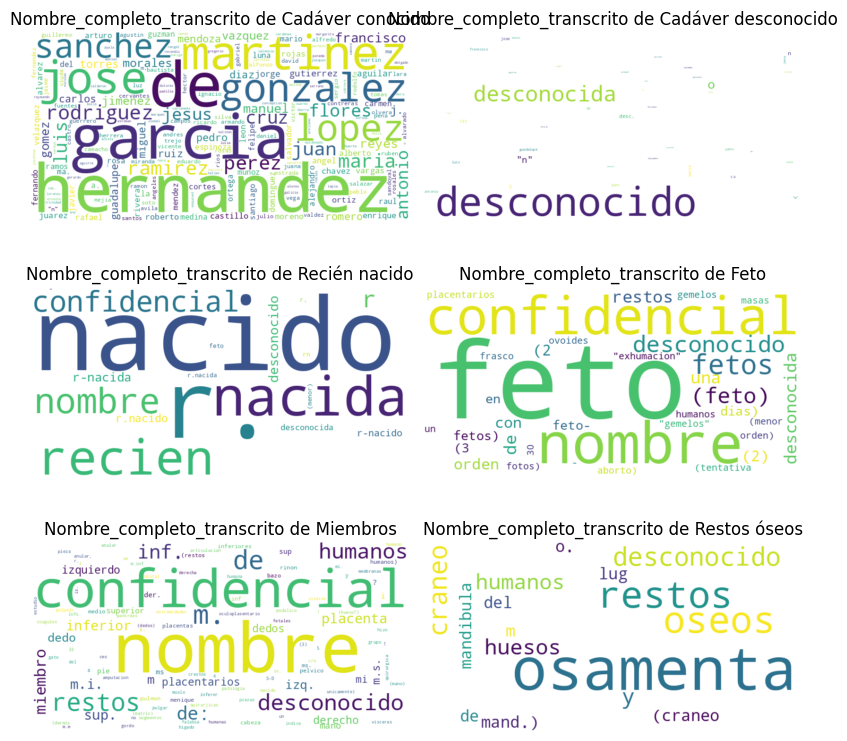

In [22]:
data = df.groupby('Tipo_restos').agg({'Nombre_completo_transcrito':join_strings_with_nans})
data = data.to_dict()['Nombre_completo_transcrito']
data

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(8,8))
axes = axes.flatten()

for ax,text in zip(axes,data.items()):
    # get word frequency
    freq = {}
    for word in text[1].split():
        freq[word] = freq.get(word, 0) + 1
    # create wordcloudx
    wordcloud = WordCloud(width=800, height=400,
                          relative_scaling=0.5, 
                          background_color='white') \
                          .generate_from_frequencies(freq)
    # Display the word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Nombre_completo_transcrito de {text[0]}")

plt.tight_layout()
#plt.savefig("imagenes/WordcloudNombre+TipoRestos.svg")
plt.show()

Nombre por identificación

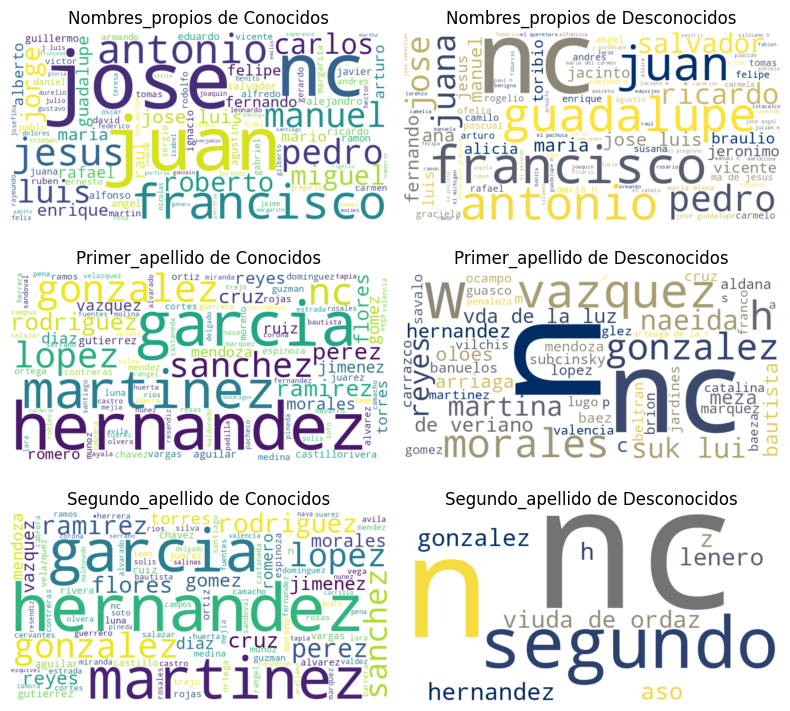

In [23]:
cols = ['Nombres_propios','Primer_apellido', 'Segundo_apellido', ]
fig, axes = plt.subplots(nrows=len(cols), ncols=2, figsize=(8, 2.5*len(cols)), sharex=True)

for i,col in enumerate(cols): 
    freq_cono = df.loc[df['Identificacion']=='Conocido',col] \
                  .apply(simplify_string, remove_special=True) \
                  .value_counts().head(100).to_dict()
    wordcloud = WordCloud(width=800, height=400,
                          relative_scaling=0.5, 
                          background_color='white') \
                          .generate_from_frequencies(freq_cono)
    # Display the word cloud
    axes[i,0].imshow(wordcloud, interpolation='bilinear')
    axes[i,0].axis('off')
    axes[i,0].set_title(f"{col} de Conocidos")
    
    freq_des = df.loc[df['Identificacion']=='Desconocido',col] \
                  .apply(simplify_string, remove_special=True) \
                  .value_counts().head(100).to_dict()
    wordcloud = WordCloud(width=800, height=400,
                          relative_scaling=0.5, 
                          colormap='cividis', background_color='white') \
                          .generate_from_frequencies(freq_des)
    # Display the word cloud
    axes[i,1].imshow(wordcloud, interpolation='bilinear')
    axes[i,1].axis('off')
    axes[i,1].set_title(f"{col} de Desconocidos")
plt.tight_layout()
#plt.savefig("imagenes/BO_Wordcloud_Nombre.svg")
plt.show()

#### Procedencia_extendido (mapa)

In [24]:
string_summary(df['Procedencia_extendido'], df['Tipo_restos'], 
               top_n=5,  other_str='Otro*',
               percen_round=3, pretty_display=True)
''

''

In [25]:
categorical_summary(df['Procedencia_alcaldia'], df['Tipo_restos'], percen_round=3, as_str=True, sort_index=False, top_n=17)

Cadáver conocido Cadáver desconocido  \
Procedencia_alcaldia                                                    
Miguel Hidalgo                      8919 (9.211%)        1849 (1.91%)   
Cuauhtemoc                          7023 (7.253%)       2794 (2.886%)   
Gustavo A Madero                    6600 (6.816%)       1874 (1.935%)   
Venustiano Carranza                 5797 (5.987%)       2860 (2.954%)   
Benito Juarez                       5921 (6.115%)       1174 (1.212%)   
Coyoacan                            5212 (5.383%)        408 (0.421%)   
Iztapalapa                            3292 (3.4%)       1058 (1.093%)   
Alvaro Obregon                      2000 (2.066%)        420 (0.434%)   
Azcapotzalco                        1583 (1.635%)        454 (0.469%)   
Iztacalco                           1305 (1.348%)        518 (0.535%)   
Tlalpan                             1368 (1.413%)        301 (0.311%)   
Xochimilco                           807 (0.833%)        305 (0.315%)   
Cuajimalpa de Morelos                449 (0.464%)        158 (0.163%)   
Tlahuac                              317 (0.327%)         66 (0.068%)   
Magdalena Contreras                   271 (0.28%)         65 (0.067%)   
Milpa Alta                           202 (0.209%)         41 (0.042%)   
Cuauhtemoc + Venustiano Carranza       8 (0.008%)          2 (0.002%)   

                                 Recién nacido          Feto      Miembros  \
Procedencia_alcaldia                                                         
Miguel Hidalgo                     67 (0.069%)  295 (0.305%)  343 (0.354%)   
Cuauhtemoc                           97 (0.1%)  435 (0.449%)  164 (0.169%)   
Gustavo A Madero                  125 (0.129%)  464 (0.479%)  222 (0.229%)   
Venustiano Carranza                43 (0.044%)  248 (0.256%)  304 (0.314%)   
Benito Juarez                      59 (0.061%)  356 (0.368%)  312 (0.322%)   
Coyoacan                           46 (0.048%)  148 (0.153%)   474 (0.49%)   
Iztapalapa                         64 (0.066%)  244 (0.252%)   36 (0.037%)   
Alvaro Obregon                     46 (0.048%)  167 (0.172%)   16 (0.017%)   
Azcapotzalco                       23 (0.024%)  154 (0.159%)   31 (0.032%)   
Iztacalco                          31 (0.032%)  168 (0.174%)   18 (0.019%)   
Tlalpan                             9 (0.009%)   65 (0.067%)    9 (0.009%)   
Xochimilco                          7 (0.007%)   40 (0.041%)    8 (0.008%)   
Cuajimalpa de Morelos               3 (0.003%)    7 (0.007%)    3 (0.003%)   
Tlahuac                               0 (0.0%)    3 (0.003%)    4 (0.004%)   
Magdalena Contreras                 3 (0.003%)   27 (0.028%)    2 (0.002%)   
Milpa Alta                          1 (0.001%)    8 (0.008%)    2 (0.002%)   
Cuauhtemoc + Venustiano Carranza      0 (0.0%)      0 (0.0%)      0 (0.0%)   

                                 Restos óseos            Total  
Procedencia_alcaldia                                            
Miguel Hidalgo                     3 (0.003%)  11476 (11.852%)  
Cuauhtemoc                         9 (0.009%)  10522 (10.867%)  
Gustavo A Madero                   7 (0.007%)    9292 (9.597%)  
Venustiano Carranza                  0 (0.0%)    9252 (9.555%)  
Benito Juarez                      1 (0.001%)     7823 (8.08%)  
Coyoacan                           5 (0.005%)    6293 (6.499%)  
Iztapalapa                         4 (0.004%)    4698 (4.852%)  
Alvaro Obregon                       0 (0.0%)    2649 (2.736%)  
Azcapotzalco                       8 (0.008%)    2253 (2.327%)  
Iztacalco                            0 (0.0%)    2040 (2.107%)  
Tlalpan                            3 (0.003%)    1755 (1.813%)  
Xochimilco                         1 (0.001%)    1168 (1.206%)  
Cuajimalpa de Morelos                0 (0.0%)      620 (0.64%)  
Tlahuac                              0 (0.0%)     390 (0.403%)  
Magdalena Contreras                1 (0.001%)     369 (0.381%)  
Milpa Alta                           0 (0.0%)     254 (0.

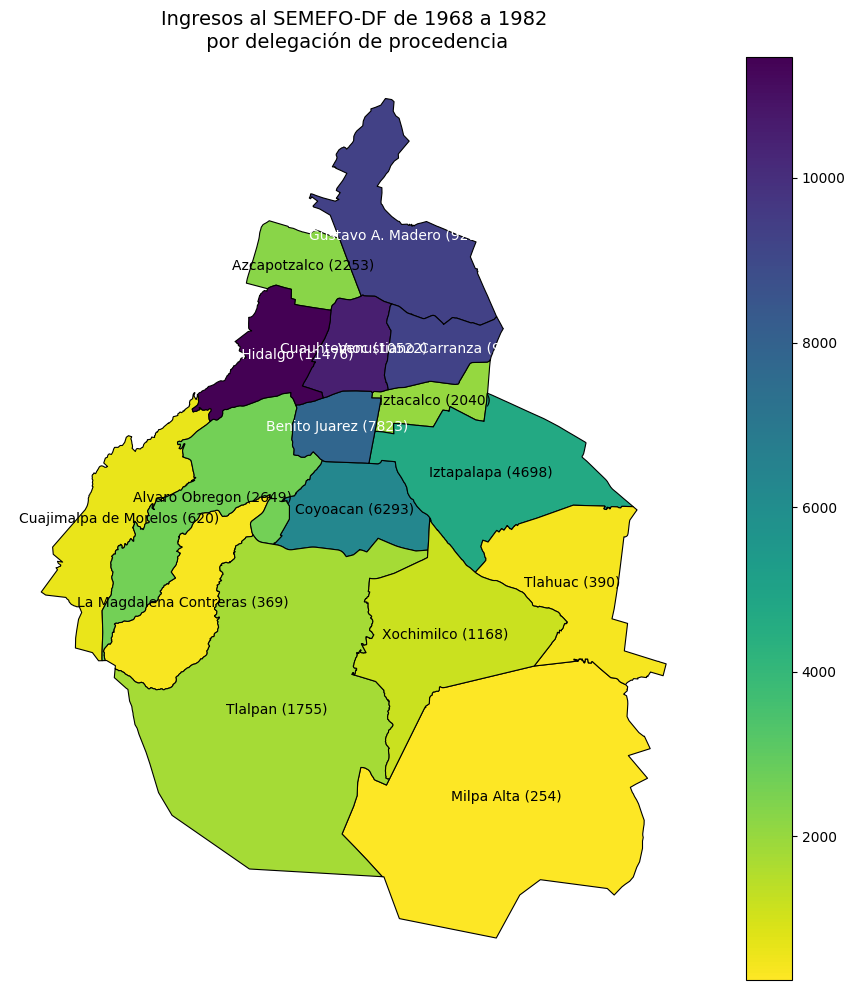

In [26]:
import geopandas as gpd

# capa de entidad y delegacion
mg_ent = gpd.read_file("catalogos/09_ciudaddemexico.zip!conjunto_de_datos", layer="09ent")
mg_mun = gpd.read_file("catalogos/09_ciudaddemexico.zip!conjunto_de_datos", layer="09mun")
mg_mun['NOMGEO'] = mg_mun['NOMGEO'].apply(unidecode)
mg_mun = mg_mun[['NOMGEO','geometry']]
mg_mun


# get freq
data = df['Procedencia_alcaldia'].value_counts(dropna=False).reset_index()
dic_rep = {'Gustavo A Madero':'Gustavo A. Madero', 'Magdalena Contreras':'La Magdalena Contreras'}
data['Procedencia_alcaldia'] = data['Procedencia_alcaldia'].replace(dic_rep)
#data.loc[len(data)] = ['Cuajimalpa de Morelos', 0]
data.columns = ['NOMGEO','freq']
# manage nan
nan_str, nan_otro = 'S-D', 'Otro'
data['NOMGEO'] = data['NOMGEO'].astype(str).replace({'nan':nan_str,nan:nan_str})
# filter 
data['NOMGEO'] = data['NOMGEO'].map({s:s for s in mg_mun['NOMGEO'].to_list() + [nan_str]}).fillna(nan_otro)
data = data.groupby('NOMGEO').sum().sort_index().reset_index()
# join with geometry
data = mg_mun.merge(data, on='NOMGEO')
#display( data )

# plot figure
fig, ax = plt.subplots(figsize=(10, 10))
data.plot(column='freq', cmap='viridis_r', linewidth=0.8, edgecolor='black', legend=True, ax=ax)

# Crear etiqueta con nombre del municipio y frecuencia entre paréntesis
data['etiqueta'] = data['NOMGEO'] + ' (' + data['freq'].astype(str) + ')'

# Añadir nombres de municipios con frecuencia
for idx, row in data.iterrows():
    if row.geometry.centroid.is_empty: continue
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    color = 'white' if row['freq'] > 7500 else 'black'
    ax.text(x, y, row['etiqueta'], fontsize=10, 
            ha='center', va='center', 
            color=color)

ax.set_title('Ingresos al SEMEFO-DF de 1968 a 1982\n por delegación de procedencia', fontsize=14)
ax.axis('off')
plt.tight_layout()
#plt.savefig("imagenes/BO_Mapa_Ingresos.svg")
plt.show()

#### Diagnostico_extendido


In [27]:
string_summary(df['Diagnostico_extendido'], df['Tipo_restos'], 
               top_n=5,  other_str='Otro*',
               percen_round=3, pretty_display=True)
''

''

### Proceso administrativo

'Numero_progresivo_transcrito', 
'Expediente_SEMEFO_transcrito',
'Foja_transcrito', 
'Observaciones'

#### Numero_progresivo
* El orden es por letra, luego fecha.
* Generalmente desconocidos, fetos, etc al final

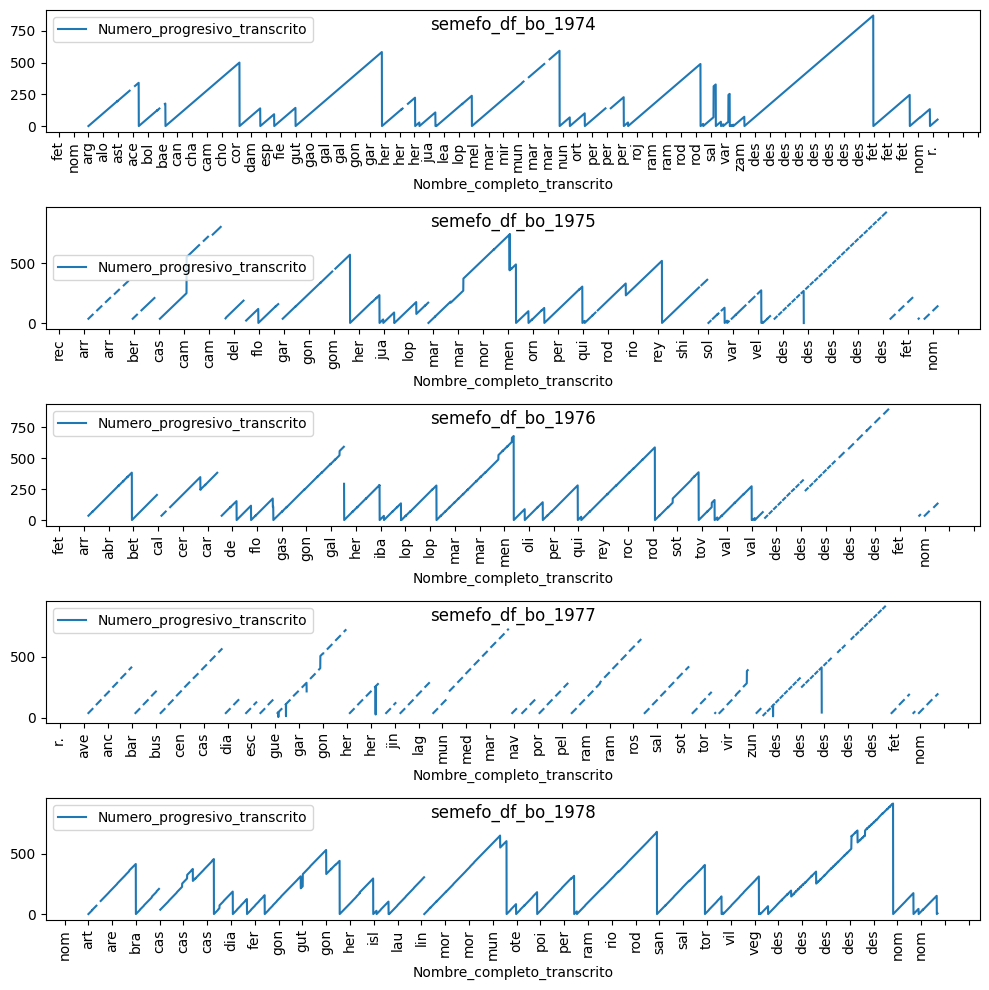

In [28]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10))


i = 0
for bit in [f'semefo_df_bo_{i}' for i in range(1974, 1979)]:
    data = df.loc[(df['Bitacora_ingresos']==bit), ['Nombre_completo_transcrito','Numero_progresivo_transcrito']]
    if data.shape[0]>0:
        data['Nombre_completo_transcrito'] = data['Nombre_completo_transcrito'].apply(lambda s: s[0:3] if type(s)==str else nan)
        data['Numero_progresivo_transcrito'] = pd.to_numeric( data['Numero_progresivo_transcrito'].replace('S-D',nan) )
        data = data.set_index('Nombre_completo_transcrito')
        axes[i].set_title(bit, y=1.0, pad=-14)
        axes[i].locator_params(axis='x', nbins=70)
        #axes[i].get_legend().remove()
        data.plot(ax=axes[i], rot=90)
        i += 1
plt.tight_layout()
plt.show()

#### Expediente_SEMEFO_transcrito

* El orden es por letra, luego fecha.
* De 1968 a 1973 en orden ortográfico + fecha
* De 1974 a 1982 desconocidos, fetos, etc al final

Exp no númericos: [nan '1-/69' '759-Bis' '26/70' '27/70' '25/71' '1971-10-01 00:00:00'
 '2196 R' '85-72' '1972-12-01 00:00:00' '29-72' '30-72' '28-72' '61-71'
 '78-72' '(90235) 1' '82-81' '3549-Bis' '57/73' 'R.L' 'RL' '39/75' '60/75'
 '6329/73' 'S/n' '34/75' '40/75' '4415 BIS' '251-76' '6725 Bis' '1080 Bis'
 '187-76' '3628 Bis' '250-76' '252-76' '6576 Bis' '2881 Bis' '6254 Bis'
 '136-Bis' '6900-75' '6903-75' '8/77' '1950 Bis' '323 Bis' '3014 bis'
 '1977-01-01 00:00:00' '2459-83' 'S-d' '359/78' '361/78' '371/78' '372/78'
 '362/78' '363/78' '379/78' '3092 Bis' '1.1/78' '1365 Bis' '5997 Bis'
 '364/78' '377/78' '366/78' '905 Bis' '376/78' '6249 bis' '360/78'
 '370/78' '374/78' '369/78' '375/78' '373/78' '378/78' '365/78' '801/79'
 '828/79' '831/79' '842/79' '824/79' '830/79' '-1-' '818/79' '827/79'
 '832/79' '834/79' '835-79' '7161-77' '375A' '816-79' '840-79' '817-79'
 '821-79' '822-79' '839-79' '829-79' '382-79' '826-79' '836-79' '838-79'
 '2721 Bis' '823-79' '837-79' '6968-77' '833-79' 

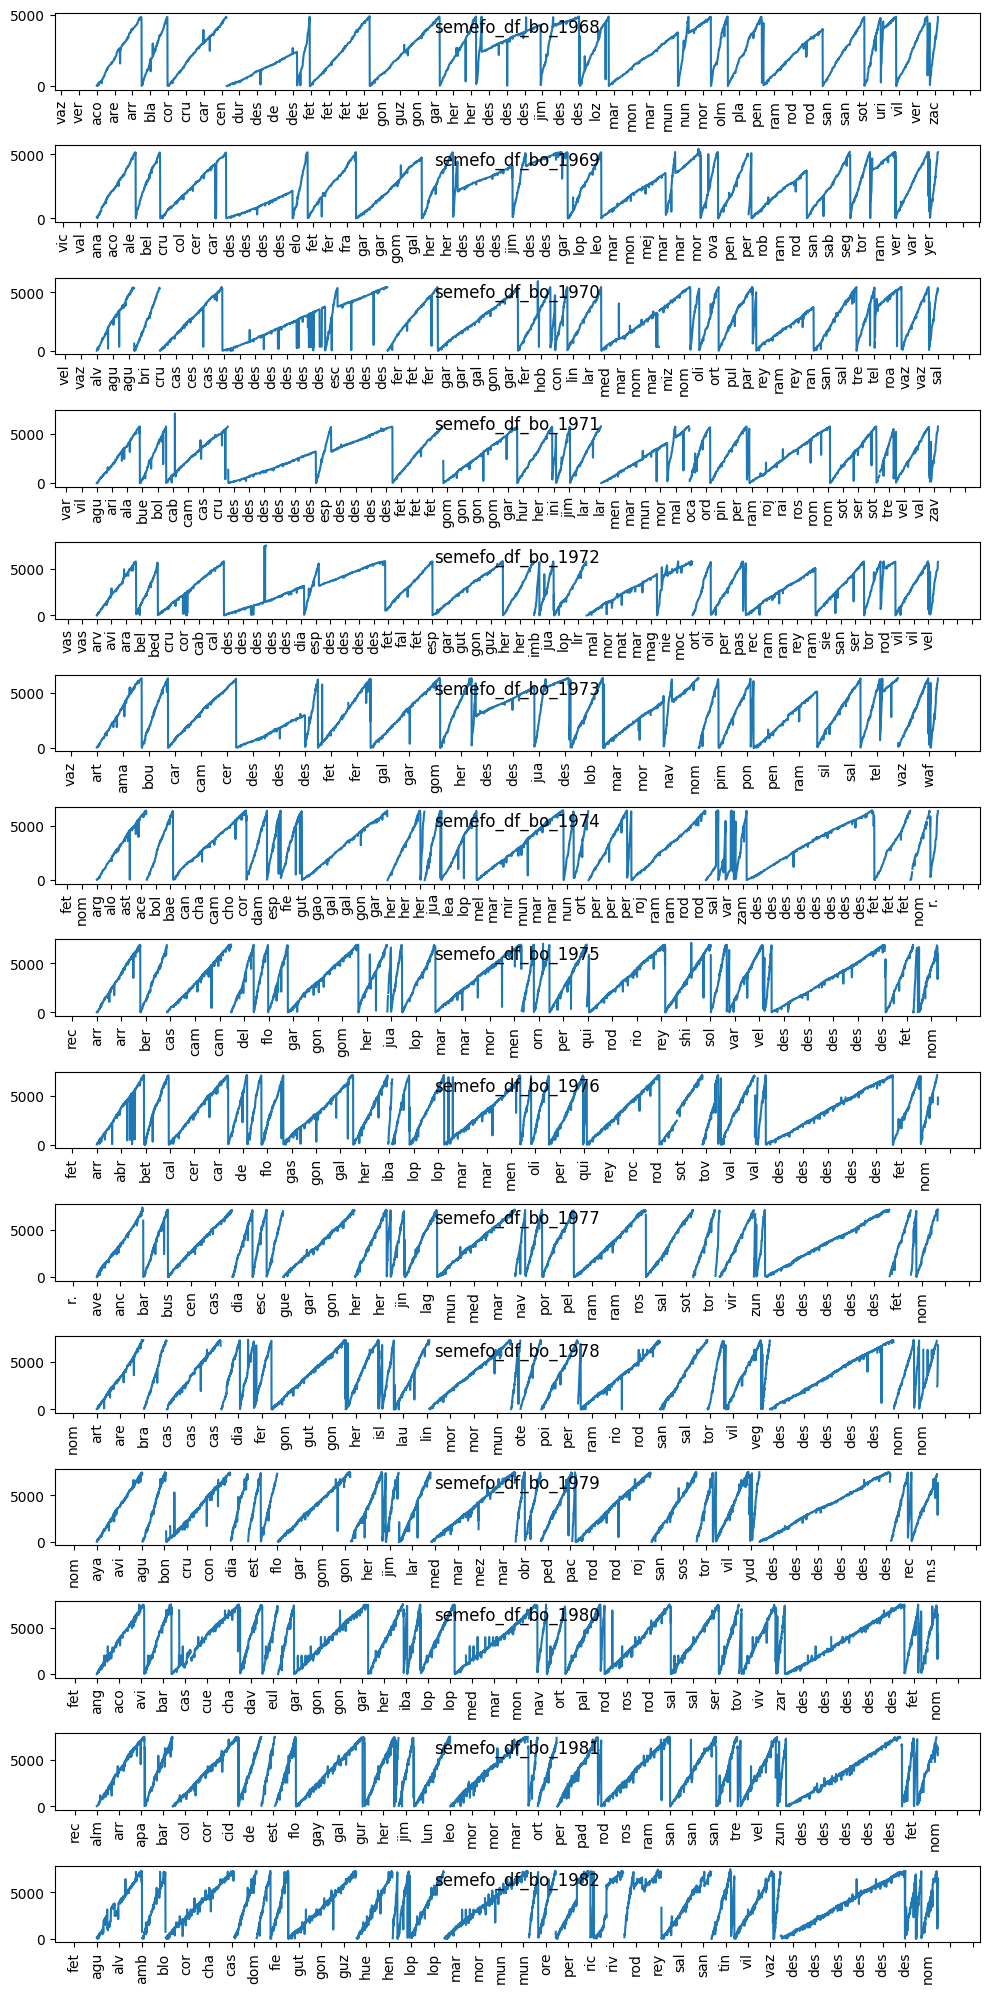

In [29]:
exp_sem = df[['Bitacora_ingresos','Nombre_completo_transcrito','Expediente_SEMEFO_transcrito']]
exp_sem.columns = ['Bitacora','Nombre','Exp']
exp_sem = to_dtype_with_errors(exp_sem, 'Exp', dtype='numeric', suffix='clean')
exp_sem

print('Exp no númericos:', exp_sem['Exp_error'].unique())

fig, axes = plt.subplots(nrows=15, ncols=1, figsize=(10, 20))

i = 0
for bit in [f'semefo_df_bo_{i}' for i in range(1968, 1983)]:
    data = exp_sem[(exp_sem['Bitacora']==bit)]
    if data.shape[0]>0:
        data['Nombre'] = data['Nombre'].apply(lambda s: s[0:3] if type(s)==str else nan)
        data.loc[data['Exp_clean']>=7500,'Exp_clean'] = nan
        data = data.set_index('Nombre')
        axes[i].set_title(bit, y=1.0, pad=-14)
        axes[i].locator_params(axis='x', nbins=70)
        data['Exp_clean'].plot(ax=axes[i], rot=90)
        axes[i].set_xlabel('')
        i += 1
plt.tight_layout()
plt.show()

#### Numero_acta_transcrito

Unir con 'Procedencia_transcrito' y 'Bitacora_ingresos'

* Pueden repetirse en diferentes fechas
* Generalmente individuales (95.51%)
* Hay grupos de 2 a 26, pueden ser ingresos asociados a un evento o coincidencias

In [30]:
data = df[['Bitacora_ingresos','Procedencia_transcrito','Numero_acta_transcrito']].replace('S-D',np.nan)
data = data.value_counts().reset_index()
display( data['count'].value_counts().sort_index() )
display(data.head(15))

count
1     64118
2      2499
3       381
4        78
5        21
6        18
7         4
8         3
9         4
10        2
12        1
13        1
26        1
Name: count, dtype: int64

Bitacora_ingresos Procedencia_transcrito Numero_acta_transcrito  count
0   semefo_df_bo_1982                    26a                    144     26
1   semefo_df_bo_1975                   TP-1                    868     13
2   semefo_df_bo_1980                     10                   1658     12
3   semefo_df_bo_1979                     1a                   3737     10
4   semefo_df_bo_1975                   TP-1                    222     10
5   semefo_df_bo_1968                3a Del.                  10009      9
6   semefo_df_bo_1974                     9a                    866      9
7   semefo_df_bo_1978                    26a                    255      9
8   semefo_df_bo_1978                    34a                   1148      9
9   semefo_df_bo_1977                    13a                   3731      8
10  semefo_df_bo_1981                      9                   4608      8
11  semefo_df_bo_1978                    22a                   1714      8
12  semefo_df_bo_1978                    37a                    149      7
13  semefo_df_bo_1981                     29                    161      7
14  semefo_df_bo_1982                    26a                    470      7

In [31]:
data = df['Procedencia_transcrito'] +'' + df['Numero_acta_transcrito']
data.value_counts().head(25)

S-DS-D           25602
26a144              27
TP-1868             13
101658              12
1a3737              11
XocoS-D             10
TP-1222             10
9a866                9
34a1148              9
26a255               9
3a Del.10009         9
13a3731              8
22a1714              8
37a149               8
IztapalapaS-D        8
94608                8
MH-CR56              7
23a1355              7
1a4284               7
29161                7
26a470               7
32a2112              7
14a2574              7
37a1039              7
29131                6
Name: count, dtype: int64

#### Foja_transcrito

Es el número de foja, va en orden por bitacora

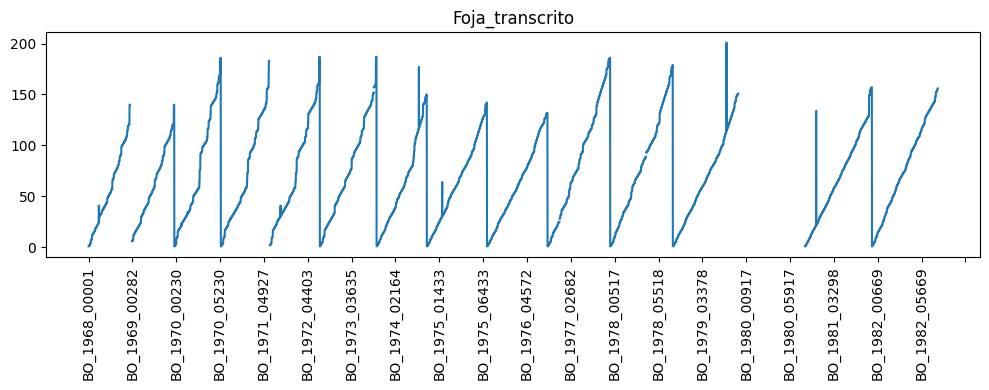

In [32]:
import re
get_digits = lambda s: int(re.findall(r'\d+',s)[0]) if type(s)==str else s
data = df['Foja_transcrito'].replace('S-D',nan).apply(get_digits)
data

fig, axes = plt.subplots(figsize=(10, 4))
axes.set_title('Foja_transcrito')
axes.locator_params(axis='x', nbins=30)
data.plot(ax=axes, rot=90)
axes.set_xlabel('')
plt.tight_layout()
plt.show()

#### Observaciones (wordcloud)

* Marcas en bitácora, más común "punto rojo en expediente semefo"
* Notas sobre transcripción, inferencia y duplicaciones

In [33]:
for tipo in df['Tipo_restos'].unique():
    print(tipo)
    display( df.loc[df['Tipo_restos']==tipo,'Observaciones'].value_counts().head(7) )
    print('\n\n')

Cadáver conocido


Observaciones
punto rojo en expediente_semefo                                                                              2417
punto rojo en expediente semefo                                                                              2087
punto rojo en numero_acta                                                                                     632
punto rojo en expediente semefo.                                                                              533
diagnostico no se ve completo                                                                                 268
de la foja 157 al 173 de esta bitacora hay registros de 1974, despues ya continuan los registros de 1973.     231
punto rojo en expediente_semefo; edad subrayada                                                               225
Name: count, dtype: int64




Cadáver desconocido


Observaciones
punto rojo en expediente_semefo                                               491
punto rojo en expediente semefo                                               261
punto rojo en expediente semefo.                                              258
marca de verificacion al final del nombre                                     234
punto rojo en numero_acta                                                     117
marca de verificacion al final del nombre; punto rojo en expediente_semefo     52
expediente_semefo no se ve completo.                                           52
Name: count, dtype: int64




Miembros


Observaciones
punto rojo en expediente_semefo                                        66
miembro inferior                                                       46
punto rojo en expediente semefo                                        40
punto rojo en numero_acta                                              21
miembro superior                                                       14
edad sin dato                                                          13
punto rojo en expediente semefo en expediente semefo se coloco s/n.    11
Name: count, dtype: int64




Feto


Observaciones
punto rojo en expediente_semefo                                                   35
punto rojo en expediente semefo                                                   26
en sexo de agrego un signo de interrogacion                                        8
el informe se entrego en una fecha posterior a la necropsia                        7
punto rojo en numero_acta                                                          7
cuadrito rojo enmarcando la fecha.                                                 7
punto rojo en expediente semefo diagnostico no se ve completo, no es inferecia     4
Name: count, dtype: int64




Restos óseos


Observaciones
osamenta                                                                4
no es posible inferir el sexo ya que no tenemos nombre_propio           2
no es posible inferir el sexo ya que no se cuenta con nombre propio     2
nota: sin autopsia. osamenta                                            1
no es posible inferir el sexo ya que no se cuenta con nombre_propio     1
osamenta (craneo y mandibula)                                           1
no es posible inferir el sexo ya que no se cuenta con nombre propio.    1
Name: count, dtype: int64




Recién nacido


Observaciones
punto rojo en expediente semefo                                                                                                                                                                                                                                                  8
cuadrito rojo enmarcando la fecha.                                                                                                                                                                                                                                               3
punto rojo en expediente_semefo                                                                                                                                                                                                                                                  3
nota: "nacida"                                                                                                                                                   

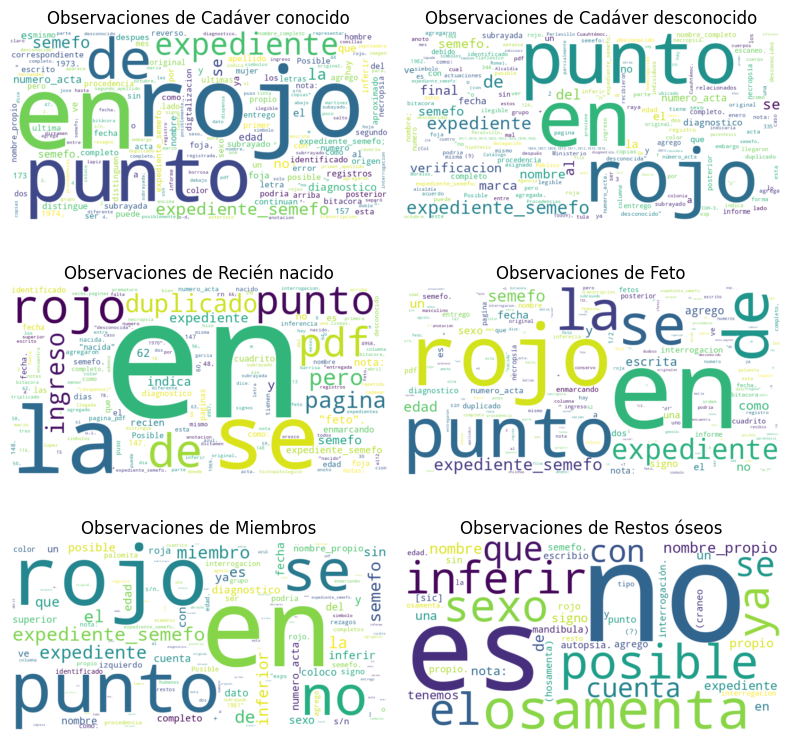

In [34]:
data = df.groupby('Tipo_restos').agg({'Observaciones':join_strings_with_nans})
data = data.to_dict()['Observaciones']
data

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(8,8))
axes = axes.flatten()

for ax,text in zip(axes,data.items()):
    # get word frequency
    freq = {}
    for word in text[1].split():
        freq[word] = freq.get(word, 0) + 1
    # create wordcloudx
    wordcloud = WordCloud(width=800, height=400,
                          relative_scaling=0.5, 
                          background_color='white') \
                          .generate_from_frequencies(freq)
    # Display the word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Observaciones de {text[0]}")

plt.tight_layout()
plt.show()

### Numéricas
#### Edad y Grupo_edad


In [35]:
numeric_summary(df['Edad_estandar'],df['Tipo_restos'],percen_round=3)

Cadáver conocido Cadáver desconocido Recién nacido  Feto Miembros  \
count            32348                6094           223  1174      329   
mean            35.845              40.057             0     0   35.587   
std             22.084               17.54             0     0   19.799   
min                  0                   0             0     0        0   
25%                 20                  28             0     0       20   
50%                 33                  40             0     0       30   
75%                 52                  50             0     0       48   
max                108                  90             0     0       91   

      Restos óseos     All  
count            3   40171  
mean            26  35.235  
std          12.49  22.127  
min             16       0  
25%             19      20  
50%             22      34  
75%             31      50  
max             40     108

Crearemos un subconjunto de datos con edades redondeadas y agrupando los mayores de 100 años

In [36]:
data_edad = df[['Tipo_restos', 'Edad_estandar', 'Edad_grupo', 'Sexo', 'Fecha_año']].dropna()
data_edad['Edad_estandar'] = data_edad['Edad_estandar'].astype(int) \
        .replace({n:100 for n in range(100,110)})
data_edad['Fecha_año'] = data_edad['Fecha_año'].astype(int)
data_edad

Tipo_restos  Edad_estandar Edad_grupo       Sexo  \
ID                                                                        
BO_1971_01274     Cadáver conocido              0     [0, 1)  Masculino   
BO_1973_00107        Recién nacido              0     [0, 1)  Masculino   
BO_1973_01155  Cadáver desconocido              0     [0, 1)   Femenino   
BO_1973_02920  Cadáver desconocido              0     [0, 1)  Masculino   
BO_1973_03132  Cadáver desconocido              0     [0, 1)  Masculino   
...                            ...            ...        ...        ...   
BO_1979_07440             Miembros             23   [20, 25)  Masculino   
BO_1979_07442             Miembros             17   [15, 20)  Masculino   
BO_1979_07451             Miembros             22   [20, 25)  Masculino   
BO_1979_07452             Miembros             65   [65, 70)   Femenino   
BO_1979_07457             Miembros             24   [20, 25)   Femenino   

               Fecha_año  
ID                        
BO_1971_01274       1971  
BO_1973_00107       1973  
BO_1973_01155       1973  
BO_1973_02920       1973  
BO_1973_03132       1973  
...                  ...  
BO_1979_07440       1979  
BO_1979_07442       1979  
BO_1979_07451       1979  
BO_1979_07452       1979  
BO_1979_07457       1979  

[40125 rows x 5 columns]

Ingresos por grupo de edad

Graficamos la frecuencia de edad

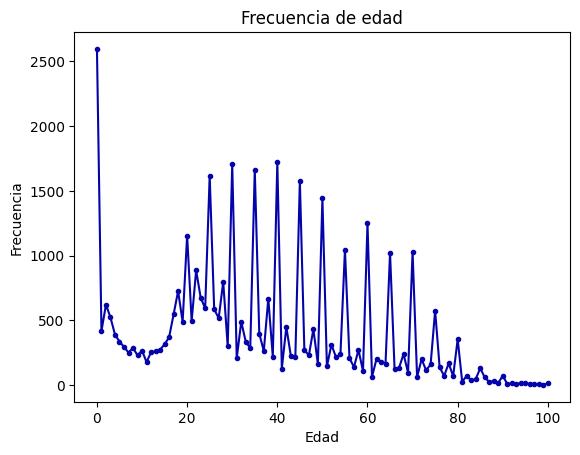

In [37]:
data_total = data_edad.value_counts('Edad_estandar').sort_index()
data_total.plot(style='.-', title="Frecuencia de edad",
               xlabel='Edad', ylabel='Frecuencia', color=dic_color['Poblacion'],
              )
plt.show()

#### Edad vs Tipo restos (chi^2)


**Prueba de independencia $\chi^2$**

Supuestos:
* Variables Categóricas
* Observaciones Independientes: 
* Frecuencias Esperadas Suficientes: usar cadaver des/conocido y miembros
* Muestra Aleatoria Simple

Resultado:
**Muestra no independientes**: Chi-square: 1597.88
**Estadísticamente significativa**: P-value: 0.0

In [38]:
#display(categorical_summary(data_edad['Edad_grupo'], data_edad['Tipo_restos'], percen_round=3, as_str=True))

data = data_edad.pivot_table(index='Edad_grupo',columns='Tipo_restos', aggfunc='size')
data = data[['Cadáver conocido','Cadáver desconocido', 'Miembros']]
#display(data)
display( round(data / data.sum(),4)*100 )

# Perform Chi-square test
chi2, p_value, dof, expected = chi2_contingency(data)
print(f"Chi-square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value}")

# visualize residuals
thr_resid = 5
resid = (data.values - expected) / np.sqrt(expected)
resid = pd.DataFrame(resid, index=data.index, columns=data.columns)
resid = resid.where(np.abs(resid) > thr_resid)
#display( resid )

Tipo_restos  Cadáver conocido  Cadáver desconocido  Miembros
Edad_grupo                                                  
[0, 1)                   2.99                 3.81      0.91
[1, 5)                   5.87                 0.87      1.52
[5, 10)                  4.18                 0.72      2.74
[10, 15)                 3.63                 0.76      4.56
[15, 20)                 7.05                 2.17     11.85
[20, 25)                10.47                 6.16     14.59
[25, 30)                 9.64                10.92     12.46
[30, 35)                 7.51                 9.46      7.29
[35, 40)                 7.67                11.76      6.38
[40, 45)                 6.26                11.48      7.60
[45, 50)                 6.20                10.71      5.78
[50, 55)                 5.67                 8.41      3.65
[55, 60)                 4.46                 5.35      3.34
[60, 65)                 4.54                 6.21      6.08
[65, 70)                 4.16                 4.34      4.26
[70, 75)                 4.01                 4.29      2.74
[75, 80)                 2.89                 1.38      2.43
[80, 85)                 1.48                 0.94      0.91
[85, 110)                1.32                 0.28      0.91

Chi-square statistic: 1597.8831649056688
Degrees of freedom: 36
P-value: 0.0


#### Edad vs Sexo (chi^2)

**Prueba de independencia $\chi^2$**

Supuestos:
* Variables Categóricas
* Observaciones Independientes:
* Frecuencias Esperadas Suficientes: quitar `Restos óseos`
* Muestra Aleatoria Simple

Resultado:
**Muestra no independientes**: Chi-square: 2254.63
**Estadísticamente significativa**: P-value: 0.0

In [39]:
#display(categorical_summary(data_edad['Edad_grupo'], data_edad['Sexo'], percen_round=3, as_str=True))

data = data_edad.pivot_table(index='Edad_grupo',columns='Sexo', aggfunc='size')
data = data.drop(columns='S-D')

# Perform Chi-square test
chi2, p_value, dof, expected = chi2_contingency(data)
print(f"Chi-square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value}")

# visualize residuals
thr_resid = 5
resid = (data.values - expected) / np.sqrt(expected)
resid = pd.DataFrame(resid, index=data.index, columns=data.columns)
resid = resid.where(np.abs(resid) > thr_resid)
#display( resid )

Chi-square statistic: 2254.63093761038
Degrees of freedom: 18
P-value: 0.0


#### Edad vs Sexo (Mann-Whitney U)

**Diferente distribución Mann-Whitney U**

Supuestos:
* Variables ordinales o continuas
* Observaciones independientes

Resultado:
**Distribuciones diferentes**: U: 150473844
**Estadísticamente significativa**: P-value: 0.0

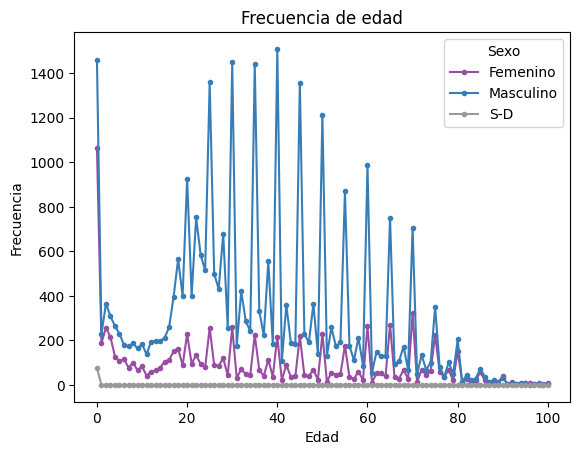

Estadístico U: 150474828.5000
Valor p: 0.0000


In [40]:
data_sexo = data_edad.pivot_table(index='Edad_estandar', columns='Sexo', aggfunc='size')
data_sexo.plot(style='.-', title="Frecuencia de edad",
               xlabel='Edad', ylabel='Frecuencia', color=dic_color,
              )
plt.show()

edad_masculino = data_edad.loc[data_edad['Sexo']=='Masculino', 'Edad_estandar'].dropna().values
edad_femenino = data_edad.loc[data_edad['Sexo']=='Femenino', 'Edad_estandar'].dropna().values
u_statistic, p_value = mannwhitneyu(edad_masculino, edad_femenino, alternative='two-sided')
print(f"Estadístico U: {u_statistic:.4f}")
print(f"Valor p: {p_value:.4f}")

## Comparación con datos históricos

Cargando archivos de referencia del INEGI

Datos tomados de:
* Secretaría de Programación y Presupuesto. (1982). Defunciones registradas en la República Mexicana, 1933-1975. Coordinación General de los Servicios Nacionales de Estadística, Geografía e Informática. ISBN 968-809-593-1.
* Instituto Nacional de Estadística, Geografía e Informática. (1994). Defunciones en los Estados Unidos Mexicanos, 1976-1992. INEGI. ISBN 970-13-0098-X.

In [41]:
años_edad = [1974,1975,1976,1977,1978,1979]
grupos_edad = ['[0, 1)', '[1, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)', 
              '[30, 35)', '[35, 40)', '[40, 45)', '[45, 50)', '[50, 55)', '[55, 60)', 
              '[60, 65)', '[65, 70)', '[70, 75)', '[75, 80)', '[80, 85)', '[85, 110)']

df_inegi = pd.read_csv('data_raw/INEGI_defunciones_sexo_1966-1984.csv', index_col='Edad_grupo')
df_inegi.columns = [int(i) if i.startswith('19') else i for i in df_inegi.columns]
df_inegi

Sexo     1966     1967     1968     1969     1970  \
Edad_grupo                                                                
Total                Total  53820.0  56693.0  59872.0  62937.0  66158.0   
Masculino        Masculino  28365.0  29981.0  31704.0  33265.0  35088.0   
[0, 1)           Masculino      NaN      NaN      NaN      NaN      NaN   
[1, 2)           Masculino      NaN      NaN      NaN      NaN      NaN   
[2, 3)           Masculino      NaN      NaN      NaN      NaN      NaN   
...                    ...      ...      ...      ...      ...      ...   
[70, 75)               S-D      NaN      NaN      NaN      NaN      NaN   
[75, 80)               S-D      NaN      NaN      NaN      NaN      NaN   
[80, 85)               S-D      NaN      NaN      NaN      NaN      NaN   
[85, 110)              S-D      NaN      NaN      NaN      NaN      NaN   
No especificado        S-D      NaN      NaN      NaN      NaN      NaN   

                    1971     1972     1973     1974     1975   1976   1977  \
Edad_grupo                                                                   
Total            64301.0  66804.0  55052.0  52767.0  50631.0  51284  47637   
Masculino        34279.0  35583.0  29211.0  28045.0  26854.0  27102  25289   
[0, 1)               NaN      NaN      NaN  13268.0  12886.0  12153  10954   
[1, 2)               NaN      NaN      NaN    527.0    533.0    616    411   
[2, 3)               NaN      NaN      NaN    203.0    206.0    257    182   
...                  ...      ...      ...      ...      ...    ...    ...   
[70, 75)             NaN      NaN      NaN      NaN      NaN      0      0   
[75, 80)             NaN      NaN      NaN      NaN      NaN      0      0   
[80, 85)             NaN      NaN      NaN      NaN      NaN      1      0   
[85, 110)            NaN      NaN      NaN      NaN      NaN      2      3   
No especificado      NaN      NaN      NaN      NaN      NaN     27      5   

                  1978   1979   1980   1981   1982   1983   1984  
Edad_grupo                                                        
Total            47741  48421  49848  48486  47715  48947  46777  
Masculino        25267  26073  26876  26210  25851  26505  24762  
[0, 1)            8402   9862   9857   8972   8614   8370   7423  
[1, 2)             358    368    282    290    289    268    241  
[2, 3)             178    170    144    115    103    117     92  
...                ...    ...    ...    ...    ...    ...    ...  
[70, 75)             5      2      1      4      5      4      3  
[75, 80)             1      2      0      5      4      2      4  
[80, 85)             1      1      1      2      5      5      4  
[85, 110)            2      2      2      5      3      3      6  
No especificado     15      2      7     11      9     19     15  

[76 rows x 20 columns]

### Asociación de ingresos y decesos DF (chi^2 y regresión lineal)

Decesos DF  Ingresos SEMEFO
1968       59872           4655.0
1969       62937           4962.0
1970       66158           5193.0
1971       64301           5415.0
1972       66804           5632.0
1973       55052           6085.0
1974       52767           5810.0
1975       50631           6684.0
1976       51284           6749.0
1977       47637           6938.0
1978       47741           6954.0
1979       48421           7194.0
1980       49848           7452.0
1981       48486           7426.0
1982       47715           7333.0

<Axes: title={'center': 'Defunciones vs ingresos al SEMEFO-DF'}>

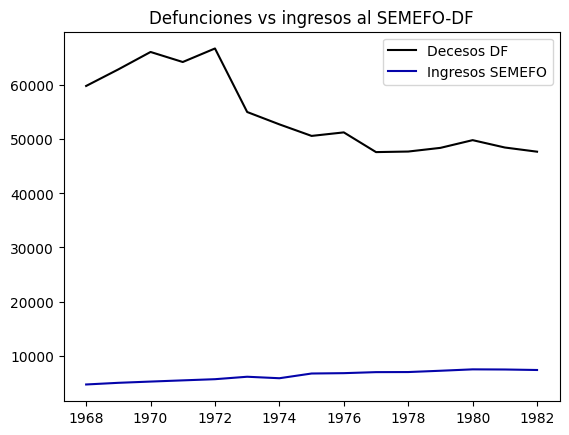

In [42]:
# Decesos/ingresos por dataset
data_inegi = df_inegi.loc['Total'].drop('Sexo').apply(int)
tipos_no = ['Miembros', 'Restos óseos']
data_semefo = df.loc[~df['Tipo_restos'].isin(tipos_no), 'Fecha_año'].value_counts()
# Graficar
data = pd.concat([data_inegi,data_semefo], axis=1).dropna()
data.columns = ['Decesos DF', 'Ingresos SEMEFO']
display(data)
data.plot(title="Defunciones vs ingresos al SEMEFO-DF", color=['black', dic_color['Poblacion']])

**Prueba de independencia $\chi^2$**

Supuestos:
* Observaciones Independientes:
* Frecuencias Esperadas Suficientes: quitar `Restos óseos`
* Muestra Aleatoria Simple

Resultado:
**Muestras no independientes**: Chi-square: 5878.77
**Estadísticamente significativa**: P-value: 0.0

In [43]:
# Perform Chi-square test
chi2, p_value, dof, expected = chi2_contingency(data)
print(f"Chi-square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value}")

# visualize residuals
thr_resid = 5
resid = (data.values - expected) / np.sqrt(expected)
resid = pd.DataFrame(resid, index=data.index, columns=data.columns)
resid = resid.where(np.abs(resid) > thr_resid)
#display( resid )

Chi-square statistic: 5878.7700752143755
Degrees of freedom: 14
P-value: 0.0


**Regresión Lineal**  
Variable independiente: año (X)  
Variable dependiente: decesos/ingresos (Y)
$$Y=\beta_0+\beta_1 X+\epsilon$$

Supuestos
* Linealidad
* Independencia
* Homocedasticidad: La varianza de los residuos es constante
* Normalidad residuos

Resultado Decesos DF:
**R-squared**: 0.730
**Pendiente $\beta_1$**: -1394.2036

Resultado Ingresos SEMEFO:
**R-squared**: 0.950
**Pendiente $\beta_1$**: 209.1143

In [44]:
# Variable independiente (Año)
X = sm.add_constant([i for i in data.index])

# Regresión Decesos DF vs Año
y1 = data['Decesos DF']
model1 = sm.OLS(y1, X).fit()
print('Decesos DF vs. Año')
print(model1.summary())

# Regresión Decesos DF vs Año
y2 = data['Ingresos SEMEFO']
model1 = sm.OLS(y2, X).fit()
print('Ingresos SEMEFO vs. Año')
print(model1.summary())

Decesos DF vs. Año
                            OLS Regression Results                            
Dep. Variable:             Decesos DF   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     35.20
Date:                Mon, 27 Oct 2025   Prob (F-statistic):           4.96e-05
Time:                        13:16:25   Log-Likelihood:                -144.37
No. Observations:                  15   AIC:                             292.7
Df Residuals:                      13   BIC:                             294.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.808e+06   4.64e+05 

/home/esther/anaconda3/envs/SEMEFO_busqueda/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.

/home/esther/anaconda3/envs/SEMEFO_busqueda/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.



### Ingresos anuales por sexo

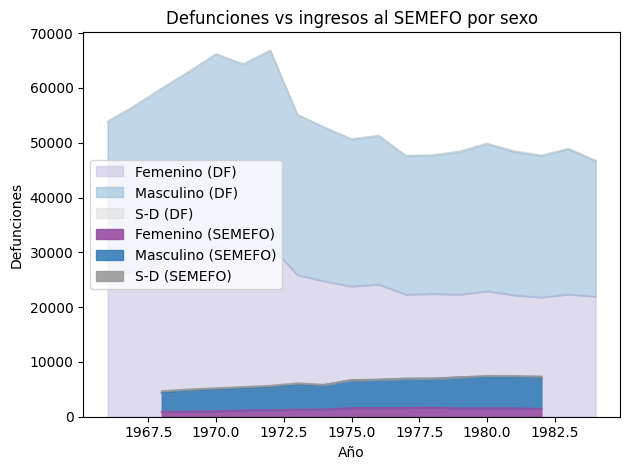

In [45]:
# Ingresos anuales semefo
data_semefo = df.loc[~df['Tipo_restos'].isin(tipos_no)] \
                .pivot_table(index='Fecha_año', columns='Sexo', aggfunc='size')
data_semefo.index = [int(i) for i in data_semefo.index]
data_semefo.columns = [f'{c} (SEMEFO)' for c in data_semefo.columns]

# Defunciones anuales DF
data_inegi = df_inegi.loc[['Femenino','Masculino','S-D']].transpose().drop('Sexo')
data_inegi.index = [i for i in data_inegi.index]
data_inegi.columns = [f'{c} (DF)' for c in data_inegi.columns]

# Plot
fig, ax = plt.subplots()
data_inegi.plot.area(ax=ax, alpha=0.5, color=dic_color)
data_semefo.plot.area(ax=ax, alpha=0.9, color=dic_color)
ax.set_xlabel('Año')
ax.set_ylabel('Defunciones')
ax.set_title('Defunciones vs ingresos al SEMEFO por sexo')
ax.legend(loc='center left')
plt.tight_layout()
#plt.savefig("imagenes/BO_Año+Sexo_DF+SEMEFO.svg")
plt.show()

### Distribución grupo etario

In [46]:
data_semefo = data_edad.loc[ (~data_edad['Tipo_restos'].isin(tipos_no)) 
                           & (data_edad['Sexo']!='S-D') \
                           & (data_edad['Fecha_año'].isin(años_edad))]
data_semefo['Sexo'] = data_semefo['Sexo'].astype(str)
data_semefo['Edad_grupo'] = data_semefo['Edad_grupo'].astype(str)
data_semefo = data_semefo.groupby(['Sexo','Edad_grupo']).size().rename('Freq').reset_index()
data_semefo['Origen'] = 'SEMEFO'

data_inegi = df_inegi.set_index(['Sexo'], append=True)[años_edad].sum(axis=1).astype(int).rename('Freq').reset_index()
data_inegi = data_inegi.loc[(data_inegi['Edad_grupo'].isin(grupos_edad)) & (data_inegi['Sexo'].isin(['Femenino','Masculino']))]
data_inegi['Origen'] = 'DF'

data_otro = pd.merge(data_inegi, data_semefo, on=['Sexo','Edad_grupo'])
data_otro['Freq'] = data_otro['Freq_x']-data_otro['Freq_y']
data_otro = data_otro[['Edad_grupo','Sexo','Freq']]
data_otro['Origen'] = 'otro'

data_tidy = pd.concat([data_semefo, data_otro, data_inegi])
data_tidy['Etiqueta'] = data_tidy['Sexo'] +' (' +data_tidy['Origen'] +')'
data_tidy['Sexo'] = data_tidy['Sexo'].astype('category')
data_tidy['Origen'] = data_tidy['Origen'].astype('category')
data_tidy['Edad_grupo'] = pd.Categorical(data_tidy['Edad_grupo'], categories=grupos_edad, ordered=True)
data_tidy = data_tidy.sort_values(['Origen','Sexo','Edad_grupo'])
data_tidy

Sexo Edad_grupo   Freq Origen          Etiqueta
27   Femenino     [0, 1)  52068     DF     Femenino (DF)
32   Femenino     [1, 5)   4600     DF     Femenino (DF)
33   Femenino    [5, 10)   1409     DF     Femenino (DF)
34   Femenino   [10, 15)   1131     DF     Femenino (DF)
35   Femenino   [15, 20)   1946     DF     Femenino (DF)
..        ...        ...    ...    ...               ...
14  Masculino   [65, 70)   9073   otro  Masculino (otro)
15  Masculino   [70, 75)   9402   otro  Masculino (otro)
16  Masculino   [75, 80)   8245   otro  Masculino (otro)
17  Masculino   [80, 85)   4837   otro  Masculino (otro)
18  Masculino  [85, 110)   6279   otro  Masculino (otro)

[114 rows x 5 columns]

Ingresos al SEMEFO vs decesos en DF

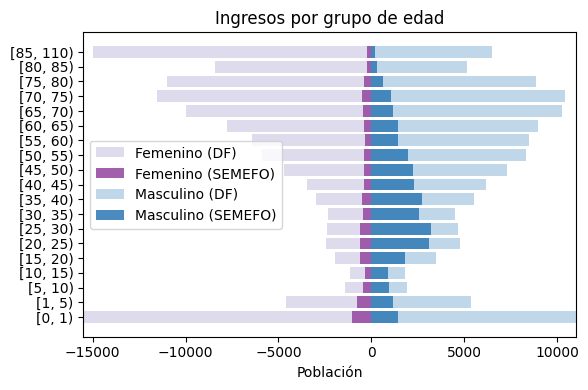

In [47]:
data = data_tidy.pivot(index='Edad_grupo', columns='Etiqueta', values='Freq')
data = data.drop(columns=(['Masculino (otro)','Femenino (otro)']))
#display( data.head() )

fig, ax = plt.subplots(figsize=(6, 4))
y = data.index
for col in data.columns:
    x = data[col]
    if 'Femenino' in col: x=-1*x
    if 'DF' in col: alpha=0.5
    else: alpha=0.9
    ax.barh(y,x,label=col,color=dic_color[col],alpha=alpha)
ax.set_xlabel('Población')
ax.set_title('Ingresos por grupo de edad')
ax.legend(loc='center left')
plt.xlim( -15500, 11000 )
plt.tight_layout()
#plt.savefig("imagenes/BO_PiramidePoblacional_DF+SEMEFO.svg")
plt.show()

Normalizando por el total de la población

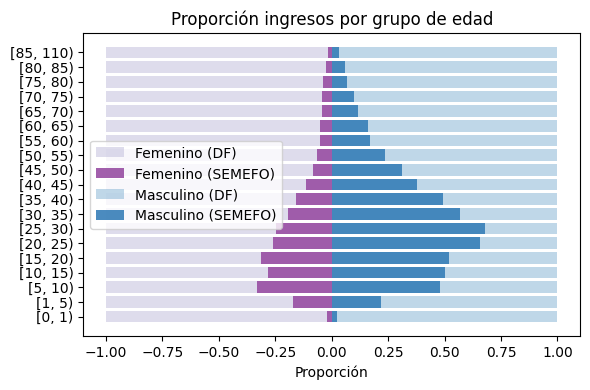

In [48]:
data_norm = pd.DataFrame()
data_norm['Femenino (DF)'] = data['Femenino (DF)']/data['Femenino (DF)']
data_norm['Femenino (SEMEFO)'] = data['Femenino (SEMEFO)']/data['Femenino (DF)']
data_norm['Masculino (DF)'] = data['Masculino (DF)']/data['Masculino (DF)']
data_norm['Masculino (SEMEFO)'] = data['Masculino (SEMEFO)']/data['Masculino (DF)']
#display(data_norm.head())

fig, ax = plt.subplots(figsize=(6, 4))
y = data_norm.index
for col in data_norm.columns:
    x = data_norm[col]
    if 'Femenino' in col: x=-1*x
    if 'DF' in col: alpha=0.5
    else: alpha=0.9
    ax.barh(y,x,label=col,color=dic_color[col],alpha=alpha)
ax.set_xlabel('Proporción')
ax.set_title('Proporción ingresos por grupo de edad')
ax.legend(loc='center left')
plt.tight_layout()
#plt.savefig("imagenes/BO_Proporcion_DF+SEMEFO.svg")
plt.show()

### Comparación con delegaciones


PearsonRResult(statistic=np.float64(0.7430059060013061), pvalue=np.float64(0.0009743315087310622))

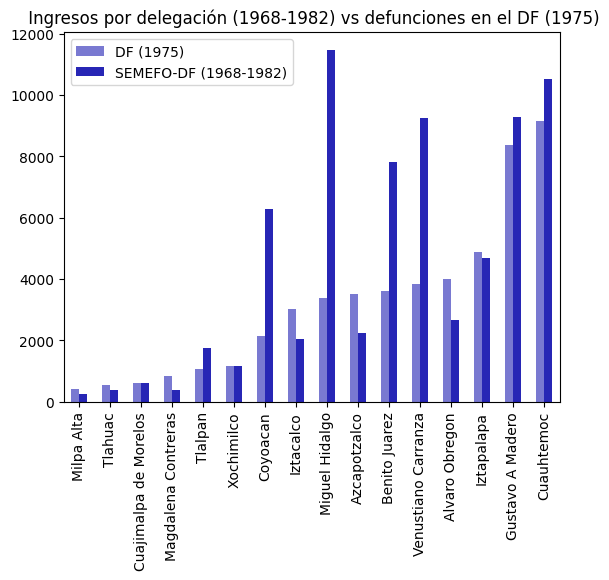

In [49]:
data_causas = pd.read_csv('data_raw/INEGI_defunciones_delegacion+causa_1975.csv', index_col='Causa')
data_del = data_causas.loc['Distrito Federal']
data_del.index = [unidecode(s).replace('.','') for s in data_del.index]
data_del

data = df['Procedencia_alcaldia'].value_counts(dropna=False)#.sort_index()
data

data = pd.concat([data_del,data], axis=1).dropna()
data.columns = ['DF (1975)', 'SEMEFO-DF (1968-1982)']
data = data.sort_values(by='DF (1975)')

data.plot.bar(title=' Ingresos por delegación (1968-1982) vs defunciones en el DF (1975)', 
              color=[dic_color['Poblacion']+alpha for alpha in ['88','dd',]])
plt.savefig('imagenes/BO_ProcedenciaDelegacion.svg')
pearsonr(data['DF (1975)'], data['SEMEFO-DF (1968-1982)'])

## Datos de identificación

### Datos faltantes en nombre

Nos centraremos en las variables que permiten la identificación de un individuo: 'Primer_apellido', 'Segundo_apellido', 'Nombres_propios'.

Es importante decir que existen nombres de dos caracteres, los cuales se usan a veces para indicar que no hay información: 'nc', 'n', '', 'sd', 'rc' o que solo se conoce la inicial en 4883/5145 (94.90%) de los casos.

In [50]:
thr_short = 2
col_identi = ['Primer_apellido', 'Segundo_apellido', 'Nombres_propios']

data = pd.concat([df[col].str.replace('[^a-zA-Z ]', '', regex=True) for col in col_identi])
data.where(data.str.len()<=thr_short).unique()

array([nan, 'nc', 'h', 'n', 'd', 'w', 'l', 'm', 'de', 'c', 'uh', 'su',
       'p', 'r', 'mm', 'o', 'cu', 'f', 'ke', 'mc', 'e', 'yu', 's', 'pe',
       'jo', 'j', 'a', '', 'ku', 'g', 'ma', 'la', 'b', 'sd', 't', 'le',
       'vi', 'z', 'vc', 'v', 'go', 'hy', 'ch', 'fe', 'sn', 'wu', 'dh',
       'mi'], dtype=object)

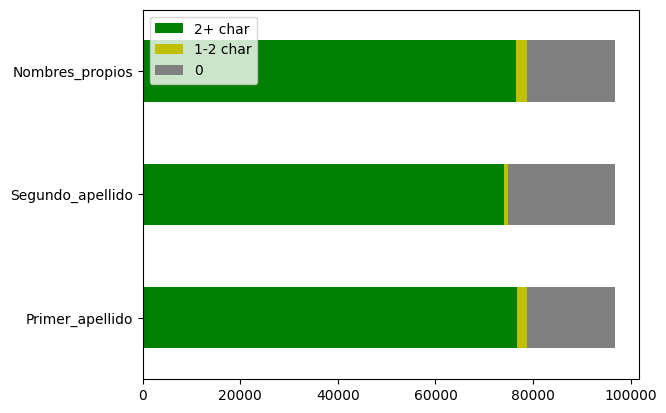

2+ char  1-2 char      0
Primer_apellido     76694      2041  18090
Segundo_apellido    74055       874  21896
Nombres_propios     76487      2219  18119

In [51]:
def length_thr(s):
    if s==0: return '0'
    elif s<=thr_short: return f"1-{thr_short} char"
    else: return f"{thr_short}+ char"


data_iden = pd.DataFrame()

data_iden['Tipo_restos'] = df['Tipo_restos']
for col in col_identi:
    data_iden[col] = df[col].str.replace('[^a-zA-Z ]', '', regex=True) \
                       .str.len().fillna(0).map( length_thr )

data = pd.concat( [data_iden[col].value_counts().rename(col) for col in col_identi] , axis=1)
data_iden_col = {f"{thr_short}+ char":'g', f"1-{thr_short} char":'y', '0':'grey'}
data = data.loc[data_iden_col.keys()].transpose()
data.plot.barh(stacked=True, color=data_iden_col)
#plt.savefig("imagenes/BO_NombreCompleto_Faltantes.svg")
plt.show()

display(data)

Clasifiquemos por el número de caracteres por campo proporciones

In [52]:
data = pd.DataFrame()
for col in col_identi:
    col_clean = df[col].str.replace('[^a-zA-Z]', '', regex=True)
    col_nan = col_clean.isna()
    col_short = col_clean.str.len()<=thr_short
    data[f'{col}_desc'] = col_nan | col_short
display(data.sum())
display(data.sum()/df.shape[0])

display(data.sum(axis=1).value_counts().sort_index())
display(data.sum(axis=1).value_counts(normalize=True).sort_index())

Primer_apellido_desc     20131
Segundo_apellido_desc    22771
Nombres_propios_desc     20347
dtype: int64

Primer_apellido_desc     0.207911
Segundo_apellido_desc    0.235177
Nombres_propios_desc     0.210142
dtype: float64

0    73382
1     3369
2      342
3    19732
Name: count, dtype: int64

0    0.757883
1    0.034795
2    0.003532
3    0.203790
Name: proportion, dtype: float64

Clasifiquemos por el número de caracteres todos los campos de nombre

In [53]:
data = pd.concat([data_iden[col].str.len()<=thr_short for col in data_iden.columns])
data

print(f'Total nombres de {thr_short} caracteres o menos: {data.sum()}/{data.shape[0]}')


Total nombres de 2 caracteres o menos: 58105/387300


### Distribución esperada de Edad (KDE)

Están fuertemente sobrerrepresentadas las edades de múltiplo de 5 en los datos.

Calculemos la densidad de la probabilidad de la población con un KDE Gaussiano.

> Un Estimador de Densidad de Kernel (KDE) es una técnica para estimar la función de densidad de probabilidad de una variable aleatoria a partir de datos.  Es un método no paramétrico, lo que significa que no asume una forma específica para la distribución. El KDE funciona colocando una pequeña curva suave (llamada kernel, como una campana) sobre cada punto de datos. Luego, suma y promedia estas curvas para crear una única curva continua que representa la distribución. La suavidad de esta curva final se controla por un parámetro llamado ancho de banda.

40125

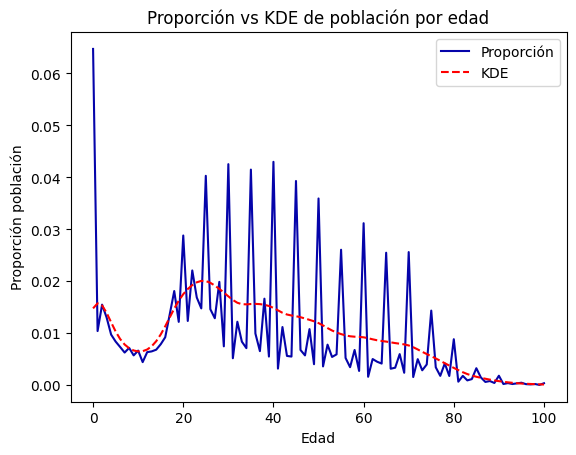

In [54]:
# Your frequency data
data_total = data_edad.value_counts('Edad_estandar').sort_index()
freq = data_total.values
values = data_total.index

# Create a "raw" data array
raw_data = np.repeat(values, freq)
total_observations = len(raw_data)
display(total_observations)

# Estimate KDE from the raw data
kde = gaussian_kde(raw_data)
kde_density = kde(values)

# Plot
plt.plot(values, freq/total_observations, label='Proporción', color=dic_color['Poblacion'])
plt.plot(values, kde_density, color='red', linestyle='--', label='KDE')
plt.title('Proporción vs KDE de población por edad')
plt.xlabel('Edad')
plt.ylabel('Proporción población')
plt.legend()
#plt.savefig("imagenes/BO_Edad+FreqKDE.svg")
plt.show()

Ahora, veamos la distancia entre la frecuencia reportada por edad y la estimada con el KDE.

La estimación de KDE es buena, ya que en promedio hay una distancia de 0.000349 entre frecuencia reportada y estimada.

In [55]:
data_kde = pd.DataFrame({'Edad':values, 
                         'Freq':freq,
                         'KDE_scaled':kde_density*total_observations,
                         'Prop':freq/total_observations, 
                         'KDE':kde_density})
data_kde = data_kde
data_kde['Diff'] = data_kde['Freq'] -  data_kde['KDE_scaled']
data_kde['Diff_norm'] = data_kde['Prop'] -  data_kde['KDE']
data_kde['Grupo'] = data_kde['Edad'].mod(5)
data_kde.loc[data_kde['Edad']<=18,'Grupo'] = 'Menor edad'
data_kde.loc[data_kde['Edad']==0,'Grupo'] = 'Cero años'
data_kde['Grupo'] = data_kde['Grupo'].replace({0:'Múltiplo 5', 1:'Otros múltiplos', 
                                               2:'Otros múltiplos', 3:'Otros múltiplos', 4:'Otros múltiplos'})
display( data_kde.drop(columns='Grupo').mean() )

Edad           50.000000
Freq          397.277228
KDE_scaled    383.276718
Prop            0.009901
KDE             0.009552
Diff           14.000509
Diff_norm       0.000349
dtype: float64

La diferencia por grupo es muy diferente:
* 0 años: error por múltiples factores, ignorar
* Menores de edad, subestimación de -776.38 (-1.93%) registros
* Múltiplo 5, sobreestimación de 10097.58 (25.16%) registros
* Otros múltiplos, subestimación de -9906.34 (-24.69%) registros
 
Dada la sobrerrepresentación de edades múltiplos de 5, podemos suponer que se estimó la edad de 1 de cada 4 ingresos.

Por lo tanto, mejor trabajar con grupos de edad.

In [56]:
data_kde.groupby('Grupo').agg(
            tamano_grupo = ('Freq', 'size'),
            tamano_reportado = ('Freq', 'sum'),
            tamano_esperado = ('KDE_scaled', 'sum'),
            diff_sum_grupo = ('Diff', 'sum'),
            diff_norm_sum_grupo = ('Diff_norm', 'sum'),
)

tamano_grupo  tamano_reportado  tamano_esperado  \
Grupo                                                              
Cero años                   1              2597       593.211222   
Menor edad                 18              6551      7331.952578   
Múltiplo 5                 17             16406      6308.432569   
Otros múltiplos            65             14571     24477.352184   

                 diff_sum_grupo  diff_norm_sum_grupo  
Grupo                                                 
Cero años           2003.788778             0.049939  
Menor edad          -780.952578            -0.019463  
Múltiplo 5         10097.567431             0.251653  
Otros múltiplos    -9906.352184            -0.246887

**Done**